# 003. XGBoost 

This notebook trains and evaluates an XGBoost model to predict the duration of Supreme Court cases (in days) from oral argument to decision.

The process involves:
1.  **Loading and Setup**: Importing libraries and the custom `XGBoostModelTrainer`.
2.  **Feature Engineering**: Renaming, cleaning, and categorizing features from the SCDB dataset.
3.  **Leakage Control**: Carefully creating distinct feature sets to prevent data leakage and establish realistic performance baselines, but also considering another aproach not focused on prediction but rather analysis of past events.
4.  **Model Training**: Using the `XGBoostModelTrainer` to train models on different feature sets.
5.  **Hyperparameter Optimization**: Employing Optuna to find the optimal XGBoost parameters.
6.  **Results & XAI**: Preparing for the final analysis and explanation of the model's behavior.

### Table of Contents 

- [003. XGBoost](#003-xgboost)
  - [1. Loading the dataset, setting up the trainere](#1-loading-the-dataset-setting-up-the-trainere)
  - [2. Variable documentation](#2-variable-documentation)
  - [3. Mapping names of the model and grouping features](#3-mapping-names-of-the-model-and-grouping-features)
  - [4. Final data preparation for modelling](#4-final-data-preparation-for-modelling)
    - [Check for uncategorized features](#check-for-uncategorized-features)
  - [5. Modelling](#5-modelling)
  - [6. Loading the model / models from saved folders / files](#6-loading-the-model--models-from-saved-folders--files)
  - [7. Results](#7-results)

##### Table of Contents generator

In [6]:
## TOC generation code:
# import sys
# import os

# # Add project root to sys.path
# notebook_dir = os.getcwd() 
# project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
# if project_root not in sys.path:
#     sys.path.insert(0, project_root)

# # Import TOC generator function
# from src.toc_generator import generate_toc_from_jupyter_notebook

# target_notebook_path = "003_XGB_XAI.ipynb" 

# toc_markdown = generate_toc_from_jupyter_notebook(target_notebook_path)

## 1. Loading the dataset, setting up the trainere

In this part we read the processed dataset. Then we import the XGBoostModelTrainer class from custom train_model.py script located in src folder. An instance (test) of this trainer is created with CUDA enabled, which will automatically use the GPU if available to speed up training. We also set up directories for saving models and plots.

In [7]:
# Libraries
import os
import sys
import random

import pandas as pd
import numpy as np

In [8]:
SEED = 420 # Choose seed
np.random.seed(SEED)
random.seed(SEED)

In [11]:
df = pd.read_csv(r'..\data\processed\scdb_processed_final.csv')

project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)
# ---------------------------------------------

# Import .py xgboost trainer 
from src.train_model import XGBoostModelTrainer, load_model_for_xai

# Initialize trainer with CUDA support - later on will be reapplied
trainer = XGBoostModelTrainer(
    output_dir="../models",
    #plot_dir="../plots", 
    enable_cuda=True,      # Automatically detects and uses GPU if available
    random_state=SEED,
    organize_by_model=True # Creates separate folders for each model
)

# ? what 4? 4 GPUS? 
print(f"Trainer initialized. Using device: {trainer.device_info['device_name'].upper()}") 

# Store all results for final comparison 
all_results = {}

CUDA detected: 1 GPU(s) available.
Trainer initialized. Using device: CUDA


In [12]:
df.columns

Index(['argument_month', 'caseOrigin_group', 'caseSource_group',
       'certReason_group', 'chief', 'complex_consolidated_disagreement',
       'days_from_term_start_to_argument', 'days_from_term_start_to_decision',
       'decision_month', 'decision_year', 'docket_category', 'had_reargument',
       'is_AdminAction_x_Economic', 'is_FedCirc_Conflict',
       'is_Govt_vs_Business', 'is_Individual_vs_Govt', 'is_State_vs_State',
       'is_late_term_argument', 'is_late_term_decision', 'issueArea_name',
       'jurisdiction_group', 'lawType_group', 'lcDisagreement',
       'lcDisposition_group', 'naturalCourt', 'num_dockets_in_case',
       'petitioner_group', 'respondent_group', 'term', 'threeJudgeFdc',
       'duration_days', 'lcDisagreement_is_missing',
       'threeJudgeFdc_is_missing', 'lcDispositionDirection_cons',
       'lcDispositionDirection_lib'],
      dtype='object')

## 2. Variable documentation

Feature documentation done with html as it is not being marked as part of outline in VS Code.

Feature documentation is crucial for understanding the dataset and ensuring that the model is trained on the correct features. The following variables are used in this notebook:


<h3>Feature Documentation</h3>

<h4>Temporal Features</h4>

<h5><code>month_of_argument</code></h5>
Month (1-12) when oral arguments were held.
<ul>
<li>Earlier months (Oct-Dec) = beginning of term</li>
<li>Later months (Apr-Jun) = end of term rush</li>
<li>May indicate workload patterns</li>
</ul>

<h5><code>month_of_decision</code></h5>
Month (1-12) when the decision was announced.
<ul>
<li>June decisions often rushed (end of term)</li>
<li>May affect deliberation quality/time</li>
</ul>

<h5><code>year_of_decision</code></h5>
Calendar year of the decision.
<ul>
<li>Captures temporal trends in court efficiency</li>
<li>May correlate with historical events/court composition</li>
</ul>

<h5><code>days_term_start_to_argument</code></h5>
Days from term start (Oct 1) to oral argument.
<ul>
<li>Early term arguments may have more deliberation time</li>
<li>Late term arguments face deadline pressure</li>
</ul>

<h5><code>days_term_start_to_decision</code></h5>
Days from term start (Oct 1) to decision.
<ul>
<li>Measures when in the term cycle decision occurs</li>
<li>Later decisions may be more complex/contentious</li>
</ul>

<h5><code>is_argument_late_in_term</code></h5>
Binary flag: 1 if argued in April or later.
<ul>
<li>Late arguments have less time before term ends</li>
<li>May indicate expedited or important cases</li>
</ul>

<h5><code>is_decision_late_in_term</code></h5>
Binary flag: 1 if decided in May or later.
<ul>
<li>Captures "June rush" effect</li>
<li>May indicate complex/divided cases</li>
</ul>

<h4>Court Structure Features</h4>

<h5><code>chief_justice_code</code></h5>
Numeric code identifying the Chief Justice.
<ul>
<li>Different chiefs may have different management styles</li>
<li>Affects court efficiency and deliberation pace</li>
</ul>

<h5><code>natural_court_period</code></h5>
Code for stable membership periods.
<ul>
<li>New justices may slow deliberations</li>
<li>Established courts may work more efficiently</li>
</ul>

<h5><code>court_term_year</code></h5>
Supreme Court term year (Oct-June).
<ul>
<li>Historical context for the case</li>
<li>Captures era-specific patterns</li>
</ul>

<h4>Case Origin and Source</h4>

<h5><code>case_origin_type</code></h5>
Simplified grouping of originating court:
<ul>
<li>'Federal': Federal district/circuit courts</li>
<li>'State': State courts</li>
<li>'Other': Territorial, unknown, special</li>
</ul>

<h5><code>case_source_type</code></h5>
Simplified grouping of court directly reviewed:
<ul>
<li>'Federal': Federal courts</li>
<li>'State': State courts  </li>
<li>'Other': Special jurisdictions</li>
</ul>

<h4>Case Type and Jurisdiction</h4>

<h5><code>case_docket_type</code></h5>
Type of Supreme Court docket:
<ul>
<li>'Merits/Other': Standard argued cases</li>
<li>'Special Jurisdiction': Original/Miscellaneous</li>
</ul>

<h5><code>jurisdiction_type</code></h5>
How case reached Supreme Court:
<ul>
<li>'Discretionary': Certiorari (court chooses)</li>
<li>'Mandatory': Appeal/Original (must hear)</li>
<li>'Other': Writs, procedural, unknown</li>
</ul>

<h5><code>cert_reason_category</code></h5>
Grouped reasons for granting certiorari:
<ul>
<li>'Substantive Reasons': Important Q, conflicts</li>
<li>'Procedural/Administrative': No reason, N/A</li>
<li>'Other': Unknown, other reasons</li>
</ul>

<h4>Legal Issues</h4>

<h5><code>specific_legal_issue_code</code></h5>
Detailed numeric code for the specific legal issue.
<ul>
<li>High cardinality (many unique values)</li>
<li>More granular than broad issue area</li>
</ul>

<h5><code>broad_issue_area</code></h5>
Major subject matter categories:
<ul>
<li>'Economic Activity': Business, commerce</li>
<li>'Criminal Procedure': Rights of accused</li>
<li>'Civil Rights': Discrimination, voting</li>
<li>'Judicial Power': Court jurisdiction</li>
<li>'First Amendment': Speech, religion</li>
<li>'Other Constitutional': Due process, federalism</li>
<li>'Other Non-Constitutional': Unions, tax, etc.</li>
</ul>

<h5><code>law_type_category</code></h5>
Type of law being interpreted:
<ul>
<li>'Constitutional': Constitution/Amendments</li>
<li>'Statutory': Federal statutes</li>
<li>'Other/Unknown': Rules, state law, unclear</li>
</ul>

<h5><code>supplemental_law_code</code></h5>
Detailed code for specific law/statute.
<ul>
<li>Supplements law_type with specifics</li>
<li>High cardinality categorical</li>
</ul>

<h4>Party Configuration</h4>

<h5><code>petitioner_type</code></h5>
Simplified petitioner (appellant) category:
<ul>
<li>'Government': US/State/Local govt & agencies</li>
<li>'Private Entities': Individuals, business</li>
<li>'Other/Unknown': Unclear or special parties</li>
</ul>

<h5><code>respondent_type</code></h5>
Simplified respondent (appellee) category:
<ul>
<li>Same categories as petitioner_type</li>
<li>Captures party dynamics</li>
</ul>

<h5><code>is_govt_vs_business_case</code></h5>
Binary: 1 if government entity vs business.
<ul>
<li>May have different deliberation patterns</li>
<li>Captures David vs Goliath dynamics</li>
</ul>

<h5><code>is_individual_vs_govt_case</code></h5>
Binary: 1 if individual vs government.
<ul>
<li>Often civil rights/liberties cases</li>
<li>May require careful deliberation</li>
</ul>

<h5><code>is_state_vs_state_case</code></h5>
Binary: 1 if state government vs state government.
<ul>
<li>Original jurisdiction cases</li>
<li>Often boundary/water rights disputes</li>
</ul>

<h4>Lower Court Information</h4>

<h5><code>lower_court_disagreement</code></h5>
Binary: 1 if explicit lower court conflict.
<ul>
<li>Major reason for Supreme Court review</li>
<li>May require more deliberation to resolve</li>
</ul>

<h5><code>lower_court_ideological_direction</code></h5>
Lower court decision ideology:
<ul>
<li>1: Conservative</li>
<li>2: Liberal  </li>
<li>3: Unspecifiable/Missing</li>
</ul>

<h5><code>lower_court_disposition_type</code></h5>
How lower court decided:
<ul>
<li>'Affirmed': Upheld lower ruling</li>
<li>'Reversed/Modified': Changed ruling</li>
<li>'Other/Unknown': Procedural, unclear</li>
</ul>

<h5><code>lower_court_disagree_ideology</code></h5>
Interaction of disagreement and ideology:
<ul>
<li>'LC_Agree_Conservative': No conflict, conservative</li>
<li>'LC_Agree_Liberal': No conflict, liberal</li>
<li>'LC_Disagree_Conservative': Conflict, conservative</li>
<li>'LC_Disagree_Liberal': Conflict, liberal</li>
<li>'LC_Unspec/Other': Unclear</li>
</ul>

<h4>Case Complexity Indicators</h4>

<h5><code>consolidated_dockets_count</code></h5>
Number of dockets consolidated in this case.
<ul>
<li>Higher = more complex (multiple related cases)</li>
<li>May require longer deliberation</li>
</ul>

<h5><code>case_had_reargument</code></h5>
Binary: 1 if case was reargued.
<ul>
<li>Indicates initial arguments insufficient</li>
<li>Strong complexity/difficulty signal</li>
</ul>

<h5><code>complexity_score_consolidated_disagree</code></h5>
Interaction: dockets_count × lower_court_disagreement.
<ul>
<li>Captures compounded complexity</li>
<li>High values = consolidated cases with conflicts</li>
</ul>

<h5><code>three_judge_district_court</code></h5>
Binary: 1 if from 3-judge district court.
<ul>
<li>Special federal court panels</li>
<li>Often important constitutional cases</li>
</ul>

<h4>Specialized Features</h4>

<h5><code>is_admin_economic_case</code></h5>
Binary: 1 if administrative agency + economic issue.
<ul>
<li>Regulatory/business intersection</li>
<li>May have specialized complexity</li>
</ul>

<h5><code>is_federal_circuit_conflict</code></h5>
Binary: 1 if federal circuit court with conflict.
<ul>
<li>Circuit splits are key cert reason</li>
<li>Requires harmonizing precedents</li>
</ul>

<h4>Interaction Features</h4>

<h5><code>issue_jurisdiction_interaction</code></h5>
Concatenated issue area + jurisdiction path.
<ul>
<li>Captures if certain issues via certain paths have distinct duration patterns</li>
</ul>

<h5><code>three_judge_issue_interaction</code></h5>
Concatenated issue area + three-judge flag.
<ul>
<li>Tests if 3-judge court effect varies by issue</li>
</ul>

<h4>Target Variable</h4>

<h5><code>case_duration_days</code></h5>
TARGET VARIABLE: Days from argument to decision.
<ul>
<li>What we're predicting</li>
<li>Measures deliberation time</li>
</ul>

<h4>Missing Value Indicators</h4>

<h5><code>lower_court_disagree_was_missing</code></h5>
Binary: 1 if lcDisagreement was originally missing.
<ul>
<li>Allows model to learn from missingness pattern</li>
<li>Missing may indicate certain case types</li>
</ul>

<h5><code>three_judge_info_was_missing</code></h5>
Binary: 1 if threeJudgeFdc was originally missing.
<ul>
<li>Captures data quality/availability patterns</li>
</ul>

<h4>Derived Features</h4>

<h5><code>decision_timing_category</code></h5>
Binned version of duration_days.
<ul>
<li>Could be used for classification instead of regression</li>
<li>Categories like 'Quick', 'Normal', 'Slow'</li>
</ul>

## 3. Mapping names of the model and grouping features

The raw dataset uses column names that are not easily recognizable (e.g., `lcDisagreement`, `threeJudgeFdc`). To improve readability, we will first map these to more recognizible names (e.g., `lower_court_disagreement`, `three_judge_district_court`).

##### New map

In [13]:
# 1. Define the complete mapping from raw column names to new descriptive names.
new_feature_name_mapping = {
    # Temporal Features
    'argument_month': 'month_of_argument',
    'decision_month': 'month_of_decision',
    'decision_year': 'year_of_decision',
    'days_from_term_start_to_argument': 'days_term_start_to_argument',
    'days_from_term_start_to_decision': 'days_term_start_to_decision',
    'is_late_term_argument': 'is_argument_late_in_term',
    'is_late_term_decision': 'is_decision_late_in_term',

    # Court Structure Features
    'chief': 'chief_justice_sname',
    'naturalCourt': 'natural_court_period',
    'term': 'court_term_year',

    # Case Origin and Source
    'caseOrigin_group': 'case_origin_type',
    'caseSource_group': 'case_source_type',

    # Case Type and Jurisdiction
    'docket_category': 'case_docket_type',
    'jurisdiction_group': 'jurisdiction_type',
    'certReason_group': 'cert_reason_category',

    # Legal Issues
    'issueArea_name': 'broad_issue_area',
    'lawType_group': 'law_type_category',

    # Party Configuration
    'petitioner_group': 'petitioner_type',
    'respondent_group': 'respondent_type',
    'is_Govt_vs_Business': 'is_govt_vs_business_case',
    'is_Individual_vs_Govt': 'is_individual_vs_govt_case',
    'is_State_vs_State': 'is_state_vs_state_case',

    # Lower Court Information
    'lcDisagreement': 'lower_court_disagreement',
    'lcDisposition_group': 'lower_court_disposition_type',
    'lcDispositionDirection_cons': 'lower_court_disposition_direction_conservative',
    'lcDispositionDirection_lib': 'lower_court_disposition_direction_liberal',

    # Case Complexity Indicators
    'num_dockets_in_case': 'consolidated_dockets_count',
    'had_reargument': 'case_had_reargument',
    'complex_consolidated_disagreement': 'complexity_score_consolidated_disagree',
    'threeJudgeFdc': 'three_judge_district_court',

    # Specialized Features
    'is_AdminAction_x_Economic': 'is_admin_economic_case',
    'is_FedCirc_Conflict': 'is_federal_circuit_conflict',

    # Target Variable
    'duration_days': 'case_duration_days',

    # Missing Value Indicators
    'lcDisagreement_is_missing': 'lower_court_disagree_was_missing',
    'threeJudgeFdc_is_missing': 'three_judge_info_was_missing'
}

# 2. Perform the renaming operation.
df_renamed = df.rename(columns=new_feature_name_mapping)

# 3. Generate statistics by comparing original columns to the mapping.
original_cols = df.columns.tolist()
changed_columns = {}
unchanged_columns = []

for col_name in original_cols:
    if col_name in new_feature_name_mapping:
        changed_columns[col_name] = new_feature_name_mapping[col_name]
    else:
        unchanged_columns.append(col_name)

# 4. Print the final report to the console.
print("--- Rename Operation Statistics ---")
print(f"Total Columns in DataFrame: {len(original_cols)}")
print(f"Columns Renamed: {len(changed_columns)}")
print(f"Columns Left Unchanged: {len(unchanged_columns)}")
print("-" * 35)

if changed_columns:
    print("\nDetails of Renamed Columns (Old Name -> New Name):")
    for old_name, new_name in changed_columns.items():
        print(f"   '{old_name}' -> '{new_name}'")

if unchanged_columns:
    print("\nDetails of Unchanged Columns (Not Found in Mapping):")
    for name in unchanged_columns:
        print(f"   '{name}'")
else:
    print("\nAll columns in the original DataFrame were found in the mapping dictionary.")

--- Rename Operation Statistics ---
Total Columns in DataFrame: 35
Columns Renamed: 35
Columns Left Unchanged: 0
-----------------------------------

Details of Renamed Columns (Old Name -> New Name):
   'argument_month' -> 'month_of_argument'
   'caseOrigin_group' -> 'case_origin_type'
   'caseSource_group' -> 'case_source_type'
   'certReason_group' -> 'cert_reason_category'
   'chief' -> 'chief_justice_sname'
   'complex_consolidated_disagreement' -> 'complexity_score_consolidated_disagree'
   'days_from_term_start_to_argument' -> 'days_term_start_to_argument'
   'days_from_term_start_to_decision' -> 'days_term_start_to_decision'
   'decision_month' -> 'month_of_decision'
   'decision_year' -> 'year_of_decision'
   'docket_category' -> 'case_docket_type'
   'had_reargument' -> 'case_had_reargument'
   'is_AdminAction_x_Economic' -> 'is_admin_economic_case'
   'is_FedCirc_Conflict' -> 'is_federal_circuit_conflict'
   'is_Govt_vs_Business' -> 'is_govt_vs_business_case'
   'is_Individu

For easier analysis and grouped feature importance plots later on (in the XAI phase), we are grouping the renamed features into logical categories.

In [14]:
print("=== ADJUSTED FEATURE CATEGORIES AND COUNTS ===\n")

# This dictionary uses the new, cleaner feature names after renaming.
# It's structured for clarity and can be used for further analysis, like with XAI.
adjusted_feature_categories = {
    'Temporal Features': [
        'month_of_argument', 'month_of_decision', 'year_of_decision',
        'days_term_start_to_argument', 'days_term_start_to_decision',
        'is_argument_late_in_term', 'is_decision_late_in_term'
    ],
    'Court Structure': [
        'chief_justice_sname', 'natural_court_period', 'court_term_year'
    ],
    'Case Origin/Source': [
        'case_origin_type', 'case_source_type'
    ],
    'Case Type/Jurisdiction': [
        'case_docket_type', 'jurisdiction_type', 'cert_reason_category'
    ],
    'Legal Issues': [
        'broad_issue_area', 'law_type_category'
    ],
    'Party Configuration': [
        'petitioner_type', 'respondent_type', 'is_govt_vs_business_case',
        'is_individual_vs_govt_case', 'is_state_vs_state_case'
    ],
    'Lower Court Info': [
        'lower_court_disagreement', 'lower_court_disposition_type',
        'lower_court_disposition_direction_conservative',
        'lower_court_disposition_direction_liberal'
    ],
    'Complexity Indicators': [
        'consolidated_dockets_count', 'case_had_reargument',
        'complexity_score_consolidated_disagree', 'three_judge_district_court'
    ],
    'Specialized Features': [
        'is_admin_economic_case', 'is_federal_circuit_conflict'
    ],
    'Missing Indicators': [
        'lower_court_disagree_was_missing', 'three_judge_info_was_missing'
    ],
    'Target Variable': [
        'case_duration_days'
    ]
}

total_features = 0
print("Feature counts per category:")
for category, features in adjusted_feature_categories.items():
    count = len(features)
    total_features += count
    print(f"- {category}: {count} features")

print(f"\nTotal features categorized: {total_features}")

=== ADJUSTED FEATURE CATEGORIES AND COUNTS ===

Feature counts per category:
- Temporal Features: 7 features
- Court Structure: 3 features
- Case Origin/Source: 2 features
- Case Type/Jurisdiction: 3 features
- Legal Issues: 2 features
- Party Configuration: 5 features
- Lower Court Info: 4 features
- Complexity Indicators: 4 features
- Specialized Features: 2 features
- Missing Indicators: 2 features
- Target Variable: 1 features

Total features categorized: 35


##### Old map

In [15]:
# # Create a mapping dictionary for cleaner column names
# feature_name_mapping = {
#     # Temporal Features
#     'argument_month': 'month_of_argument',
#     'decision_month': 'month_of_decision', 
#     'decision_year': 'year_of_decision',
#     'days_from_term_start_to_argument': 'days_term_start_to_argument',
#     'days_from_term_start_to_decision': 'days_term_start_to_decision',
#     'is_late_term_argument': 'is_argument_late_in_term',
#     'is_late_term_decision': 'is_decision_late_in_term',
    
#     # Court Structure Features
#     'chief': 'chief_justice_sname',
#     'naturalCourt': 'natural_court_period',
#     'term': 'court_term_year',
    
#     # Case Origin and Source
#     'caseOrigin_group': 'case_origin_type',
#     'caseSource_group': 'case_source_type',
    
#     # Case Type and Jurisdiction
#     'docket_category': 'case_docket_type',
#     'jurisdiction_group': 'jurisdiction_type',
#     'certReason_group': 'cert_reason_category',
    
#     # Legal Issues
#     'issue': 'specific_legal_issue_code',
#     'issueArea_name': 'broad_issue_area',
#     'lawType_group': 'law_type_category',
#     'lawSupp': 'supplemental_law_code',
    
#     # Party Configuration
#     'petitioner_group': 'petitioner_type',
#     'respondent_group': 'respondent_type',
#     'is_Govt_vs_Business': 'is_govt_vs_business_case',
#     'is_Individual_vs_Govt': 'is_individual_vs_govt_case',
#     'is_State_vs_State': 'is_state_vs_state_case',
    
#     # Lower Court Information
#     'lcDisagreement': 'lower_court_disagreement',
#     'lcDispositionDirection': 'lower_court_ideological_direction',
#     'lcDisposition_group': 'lower_court_disposition_type',
#     'lc_disagree_direction': 'lower_court_disagree_ideology',
    
#     # Case Complexity Indicators
#     'num_dockets_in_case': 'consolidated_dockets_count',
#     'had_reargument': 'case_had_reargument',
#     'complex_consolidated_disagreement': 'complexity_score_consolidated_disagree',
#     'threeJudgeFdc': 'three_judge_district_court',
    
#     # Specialized Features
#     'is_AdminAction_x_Economic': 'is_admin_economic_case',
#     'is_FedCirc_Conflict': 'is_federal_circuit_conflict',
    
#     # Interaction Features
#     'issue_x_jurisdiction': 'issue_jurisdiction_interaction',
#     'threeJudge_x_issue': 'three_judge_issue_interaction',
    
#     # Target Variable
#     'duration_days': 'case_duration_days',
    
#     # Missing Value Indicators
#     'lcDisagreement_is_missing': 'lower_court_disagree_was_missing',
#     'threeJudgeFdc_is_missing': 'three_judge_info_was_missing',
    
#     # Derived Features
#     'decision_timing_bin': 'decision_timing_category'
# }

# # Apply the mapping to rename columns
# #df = df.rename(columns=feature_name_mapping)
# print(df.columns.tolist())
# #print(df.shape[1])

For easier analysis and grouped feature importance plots later on (in the XAI phase), we are grouping the renamed features into logical categories.

In [16]:
# print("=== FEATURE CATEGORIES AND COUNTS ===\n")

# feature_categories = {
#     'Temporal Features': ['month_of_argument', 'month_of_decision', 'year_of_decision', 
#                             'days_term_start_to_argument', 'days_term_start_to_decision',
#                             'is_argument_late_in_term', 'is_decision_late_in_term'],
#     'Court Structure': ['chief_justice_sname', 'natural_court_period', 'court_term_year'],
#     'Case Origin/Source': ['case_origin_type', 'case_source_type'],
#     'Case Type/Jurisdiction': ['case_docket_type', 'jurisdiction_type', 'cert_reason_category'],
#     'Legal Issues': ['specific_legal_issue_code', 'broad_issue_area', 'law_type_category', 'supplemental_law_code'],
#     'Party Configuration': ['petitioner_type', 'respondent_type', 'is_govt_vs_business_case',
#                            'is_individual_vs_govt_case', 'is_state_vs_state_case'],
#     'Lower Court Info': ['lower_court_disagreement', 'lower_court_ideological_direction',
#                         'lower_court_disposition_type', 'lower_court_disagree_ideology'],
#     'Complexity Indicators': ['consolidated_dockets_count', 'case_had_reargument',
#                              'complexity_score_consolidated_disagree', 'three_judge_district_court'],
#     'Specialized Features': ['is_admin_economic_case', 'is_federal_circuit_conflict'],
#     'Interaction Features': ['issue_jurisdiction_interaction', 'three_judge_issue_interaction'],
#     'Missing Indicators': ['lower_court_disagree_was_missing', 'three_judge_info_was_missing'],
#     'Target/Derived': ['case_duration_days', 'decision_timing_category']
# }

# for category, features in feature_categories.items():
#     print(f"{category}: {len(features)} features")
    
# print(f"\nTotal features: {sum(len(f) for f in feature_categories.values())}")

## 4. Final data preparation for modelling

In this section the final cleaning and preparation of the data before it's fed into the model is performed. 

Key steps include:
- **Dropping leaky or problematic features**: Removing columns that wouldn't be available at prediction time or that are direct derivatives of the target.
- **Managing cardinality**: Grouping rare categorical values to prevent overfitting.
- **Defining feature types**: Explicitly identifying numerical, binary, and categorical features for the preprocessing pipeline.
- **Creating distinct feature sets**: Building `basic`, `leakage_controlled`, and `full_with_leakage` sets to properly evaluate the model's predictive power (with potential data leakage) and without data leakage.

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
import warnings
warnings.filterwarnings('ignore')


# ========================================
# STEP 1: Apply Feature Renaming ( already done above, but kept for clarity)
# ========================================

print("=== STEP 1: Renaming Features ===")
df_renamed = df.rename(columns=new_feature_name_mapping) #feature_name_mapping
print(f"Features renamed. New shape: {df_renamed.shape}")


# ========================================
# STEP 2: Handle Problematic Features
# ========================================

print("\n=== STEP 2: Handling Problematic Features ===")

# 2.1: Drop high-cardinality interaction features and clear leakage
features_to_drop = [
    'case_had_reargument'  # STRONG LEAKAGE: only known AFTER initial arguments; excluded from each set
]

print(f"Dropping {len(features_to_drop)} problematic features...")
print("Reasons for dropping:")
print("  - case_had_reargument: Strong leakage - only known after arguments fail")


df_cleaned = df_renamed.drop(columns=[f for f in features_to_drop if f in df_renamed.columns])
print(f"New shape after dropping: {df_cleaned.shape}")

=== STEP 1: Renaming Features ===
Features renamed. New shape: (9534, 35)

=== STEP 2: Handling Problematic Features ===
Dropping 1 problematic features...
Reasons for dropping:
  - case_had_reargument: Strong leakage - only known after arguments fail
New shape after dropping: (9534, 34)


In [18]:
df_cleaned["broad_issue_area"].value_counts(dropna=False)

broad_issue_area
Economic Activity           2152
Criminal Procedure          1895
Civil Rights                1498
Judicial Power              1215
Other Non-Constitutional     998
Other Constitutional         968
First Amendment              740
NaN                           68
Name: count, dtype: int64

In [32]:
# Fill missing broad_issue_area with 'Unknown' and show updated counts
df_cleaned["broad_issue_area"].fillna("Unknown", inplace=True)

# 1. Seasonality features (NOT LEAKAGE)
df_cleaned['arg_month_sin'] = np.sin(2 * np.pi * df_cleaned['month_of_argument']/12.0)
df_cleaned['arg_month_cos'] = np.cos(2 * np.pi * df_cleaned['month_of_argument']/12.0)

# 2. Jurisdiction × Issue interaction (NOT LEAKAGE)
df_cleaned['jurisdiction_x_issue'] = (
    df_cleaned['jurisdiction_type'].astype(str) + '_X_' + 
    df_cleaned['broad_issue_area'].astype(str)
)

# 3. Additional temporal features (NOT LEAKAGE)
df_cleaned['quarter_of_argument'] = df_cleaned['month_of_argument'].apply(
    lambda x: (x-1)//3 + 1
)
df_cleaned['is_summer_recess'] = df_cleaned['month_of_argument'].isin([7, 8]).astype(int)

Rationale for Data Leakage Exclusions 

The guiding principle for excluding these variables is to prevent **data leakage**. For a predictive model, we can only use information that would be available at the exact moment of prediction (in this case, immediately after oral arguments). Any variable that is created using information about the final decision itself must be excluded from this set. On the other hand we have also set if features that is used for analysis of past events, not for prediction, and therefore can be included in the feature set.

1. Variables: `days_term_start_to_decision`, `month_of_decision`, `year_of_decision`

* **Reason for Exclusion:** These features are directly calculated from the final decision date. At the time of prediction, this date is a future event and is therefore unknown. Including them would be equivalent to giving the model the answers before the test.

2. Variable: `is_decision_late_in_term`

* **Reason for Exclusion:** This is a more subtle but critical case of leakage. Even though you know the court's calendar and when the term generally ends, this feature **requires knowing the `month_of_decision` for a specific case** to be calculated. Since the decision month is an unknown future event at the time of prediction, this feature cannot be created without using future information. It is therefore a source of data leakage and must be excluded from the predictive feature set.

In [ ]:
# ========================================
# STEP 3: Separate Features by Type
# ========================================

print("\n=== STEP 3: Identifying Feature Types ===")

# Define numerical features (continuous values)
numerical_features = [
    'month_of_argument',
    'month_of_decision', 
    'year_of_decision',
    'days_term_start_to_argument',
    'days_term_start_to_decision',
    'natural_court_period',
    'court_term_year',
    'lower_court_disagreement',
    'consolidated_dockets_count',
    'complexity_score_consolidated_disagree',
    'three_judge_district_court',
    'arg_month_cos', # new testing
    'arg_month_sin', # new testing
    'quarter_of_argument ' # new testing
]

# Define binary features (0/1 flags)
binary_features = [
    'is_argument_late_in_term',
    'is_decision_late_in_term',
    'is_govt_vs_business_case',
    'is_individual_vs_govt_case',
    'is_state_vs_state_case',
    'is_admin_economic_case',
    'is_federal_circuit_conflict',
    'lower_court_disagree_was_missing',
    'three_judge_info_was_missing',
    'lower_court_disposition_direction_conservative', 
    'lower_court_disposition_direction_liberal',
    'is_summer_recess ' # new testing    
]

# Define categorical features (may need encoding)
categorical_features = [
    'case_origin_type',
    'case_source_type',
    'case_docket_type',
    'jurisdiction_type',
    'cert_reason_category',
    'broad_issue_area',
    'law_type_category',
    'petitioner_type',
    'respondent_type',
    'lower_court_disposition_type',
    'chief_justice_sname',
    'jurisdiction_x_issue' # new testing
]

# Filter definitions by columns existing in df_cleaned
numerical_features = [f for f in numerical_features if f in df_cleaned.columns]
binary_features = [f for f in binary_features if f in df_cleaned.columns]
categorical_features = [f for f in categorical_features if f in df_cleaned.columns]

# Ensure features are in at most one list
cat_set = set(categorical_features)
bin_set = set(binary_features)

temp_binary = []
for f in binary_features:
    if f not in cat_set:
        temp_binary.append(f)
binary_features = temp_binary
bin_set = set(binary_features)

temp_numerical = []
for f in numerical_features:
    if f not in cat_set and f not in bin_set:
        temp_numerical.append(f)
numerical_features = temp_numerical

print(f"Numerical features identified: {len(numerical_features)}")
print(f"Binary features identified: {len(binary_features)}")
print(f"Categorical features identified: {len(categorical_features)}")


# ========================================
# STEP 4: Create Feature Sets for Modeling
# ========================================
print("\n=== STEP 4: Creating Feature Sets ===")

# Define clear leakage variables (information not available at prediction time)
clear_leakage_vars = [ # without the reargument as it is already dropped
    'days_term_start_to_decision',  # Requires knowing decision date
    'month_of_decision',            # Decision month unknown at argument time
    'year_of_decision',             # Decision year unknown at argument time
    'is_decision_late_in_term'      # Also requires knowing decision date
]

# Target variable (excluded from all feature sets)
model_input_exclusions = ['case_duration_days']

# --- 4.1: Basic Feature Set ---
# Core features that are most reliable and interpretable
basic_features = [
    # Temporal (known at argument time)
    'month_of_argument', 
    'days_term_start_to_argument',
    'is_argument_late_in_term',
    # Court
    'court_term_year', 
    'natural_court_period',
    'chief_justice_sname',
    # Case type
    'case_docket_type', 
    'jurisdiction_type', 
    'broad_issue_area',
    # Parties
    'petitioner_type', 
    'respondent_type',
    # Complexity
    'consolidated_dockets_count',
    # Lower court
    'lower_court_disagreement', 
    'lower_court_disposition_type'
]

basic_features_final = [f for f in basic_features if f in df_cleaned.columns]
print(f"\nBasic feature set includes core predictors known at argument time")
print(f"Basic features: {len(basic_features_final)} features")

# --- 4.2: Full Feature Set WITH Leakage ---
# All features except target - includes decision-time information
# This helps understand upper bound of predictive performance
full_features_with_leakage_final = [
    col for col in df_cleaned.columns if col not in model_input_exclusions
]
print(f"\nFull feature set includes ALL features (including leakage)")
print(f"Full with leakage: {len(full_features_with_leakage_final)} features")

# --- 4.3: Leakage-Controlled Feature Set ---
# All features except those with clear leakage
# This is the recommended set for actual prediction
leakage_controlled_features_final = [
    f for f in full_features_with_leakage_final
    if f not in clear_leakage_vars
]
print(f"\nLeakage-controlled set excludes decision-time information")
print(f"Leakage-controlled: {len(leakage_controlled_features_final)} features")

# Show what's being excluded as leakage
leakage_features_in_data = [f for f in clear_leakage_vars if f in full_features_with_leakage_final]
print(f"\nFeatures identified as leakage and excluded from controlled set:")
for feat in leakage_features_in_data:
    print(f"  - {feat}")


# ========================================
# STEP 5 & 6: Prepare Data and Configurations
# ========================================
print("\n=== STEP 5 & 6: Preparing Data and Configurations for Each Feature Set ===")

if 'case_duration_days' not in df_cleaned.columns:
    raise ValueError("'case_duration_days' target variable not found in df_cleaned.")
y = df_cleaned['case_duration_days']

# Using the three specifically requested feature sets
feature_sets_to_prepare = {
    "basic": basic_features_final,
    "full_with_leakage": full_features_with_leakage_final,
    "leakage_controlled": leakage_controlled_features_final
}

all_model_inputs = {}

for set_name, selected_features_list in feature_sets_to_prepare.items():
    print(f"\n--- Preparing for feature set: {set_name.upper()} ---")
    
    X_current = df_cleaned[selected_features_list].copy()
    print(f"X_{set_name} shape: {X_current.shape}")

    current_numerical_typed = [f for f in numerical_features if f in X_current.columns]
    current_binary_typed = [f for f in binary_features if f in X_current.columns]
    current_categorical_typed = [f for f in categorical_features if f in X_current.columns]
    
    # For XGBoost, numerical and binary can be treated the same
    current_numerical_for_trainer = current_numerical_typed + current_binary_typed
    current_categorical_for_trainer = current_categorical_typed
    
    # Sanity check
    trainer_features_set = set(current_numerical_for_trainer + current_categorical_for_trainer)
    x_current_set = set(X_current.columns)
    if trainer_features_set != x_current_set:
        print(f"Warning for set '{set_name}': Feature mismatch detected")
        missing_from_trainer = x_current_set - trainer_features_set
        if missing_from_trainer:
            print(f"  Missing from trainer config: {missing_from_trainer}")

    print(f"For XGBoostModelTrainer ({set_name} set):")
    print(f"  Numerical + Binary features: {len(current_numerical_for_trainer)}")
    print(f"  Categorical features: {len(current_categorical_for_trainer)}")

    all_model_inputs[set_name] = {
        'X': X_current,
        'y': y,
        'numerical_for_trainer': current_numerical_for_trainer,
        'categorical_for_trainer': current_categorical_for_trainer,
        'feature_list': selected_features_list 
    }

print(f"\nTarget variable statistics:")
print(f"  Mean duration: {y.mean():.1f} days")
print(f"  Median duration: {y.median():.1f} days")
print(f"  Std deviation: {y.std():.1f} days")
print(f"  Min: {y.min():.0f} days, Max: {y.max():.0f} days")


# ========================================
# STEP 7: Feature Importance Analysis Setup
# ========================================
print("\n=== STEP 7: Feature Analysis Preparation ===")

# Using leakage_controlled set for feature grouping
if 'leakage_controlled' in all_model_inputs:
    selected_features_for_groups = all_model_inputs['leakage_controlled']['feature_list']

    feature_groups = {
        'Temporal': [f for f in ['month_of_argument', 'days_term_start_to_argument', 'is_argument_late_in_term'] 
                     if f in selected_features_for_groups],
        'Court Structure': [f for f in ['chief_justice_sname', 'natural_court_period', 'court_term_year'] 
                           if f in selected_features_for_groups],
        'Case Type': [f for f in ['case_docket_type', 'jurisdiction_type', 'cert_reason_category', 
                                 'case_origin_type', 'case_source_type'] 
                     if f in selected_features_for_groups],
        'Legal Issues': [f for f in ['broad_issue_area', 'law_type_category', 'specific_legal_issue_grouped'] 
                        if f in selected_features_for_groups],
        'Parties': [f for f in ['petitioner_type', 'respondent_type', 'is_govt_vs_business_case', 
                               'is_individual_vs_govt_case', 'is_state_vs_state_case'] 
                   if f in selected_features_for_groups],
        'Lower Court': [f for f in ['lower_court_disagreement', 'lower_court_disposition_type', 
                                   'lower_court_ideological_direction', 'lower_court_disagree_ideology'] 
                       if f in selected_features_for_groups],
        'Complexity': [f for f in ['consolidated_dockets_count', 'complexity_score_consolidated_disagree', 
                                  'three_judge_district_court'] 
                      if f in selected_features_for_groups],
        'Missing Indicators': [f for f in ['lower_court_disagree_was_missing', 'three_judge_info_was_missing'] 
                              if f in selected_features_for_groups],
        'Specialized': [f for f in ['is_admin_economic_case', 'is_federal_circuit_conflict'] 
                       if f in selected_features_for_groups]
    }
    
    # Remove empty groups
    feature_groups = {name: f_list for name, f_list in feature_groups.items() if f_list}

    print("\nFeature groups for importance analysis:")
    for group, features_in_group in feature_groups.items():
        print(f"  {group}: {len(features_in_group)} features")
        
    # Show feature distribution across sets
    print("\n=== Feature Set Comparison ===")
    print(f"Basic set: {len(all_model_inputs['basic']['feature_list'])} features")
    print(f"Leakage-controlled set: {len(all_model_inputs['leakage_controlled']['feature_list'])} features")
    print(f"Full with leakage set: {len(all_model_inputs['full_with_leakage']['feature_list'])} features")
    
    # Features only in full set (leakage features)
    leakage_only = set(all_model_inputs['full_with_leakage']['feature_list']) - set(all_model_inputs['leakage_controlled']['feature_list'])
    if leakage_only:
        print(f"\nLeakage features (only in full set): {leakage_only}")
    
    # Additional features in leakage-controlled vs basic
    additional_controlled = set(all_model_inputs['leakage_controlled']['feature_list']) - set(all_model_inputs['basic']['feature_list'])
    if additional_controlled:
        print(f"\nAdditional features in leakage-controlled vs basic:")
        for feat in sorted(additional_controlled):
            print(f"  - {feat}")


print("\n=== PREPROCESSING COMPLETE ===")
print("Ready for model training with three feature sets:")
print("1. 'basic': Core reliable features for baseline")
print("2. 'full_with_leakage': All features to understand upper bound")
print("3. 'leakage_controlled': Recommended for actual predictions")
print("\nall_model_inputs dictionary contains X, y, and feature configurations for each set.")


=== STEP 3: Identifying Feature Types ===
Numerical features identified: 13
Binary features identified: 11
Categorical features identified: 12

=== STEP 4: Creating Feature Sets ===

Basic feature set includes core predictors known at argument time
Basic features: 14 features

Full feature set includes ALL features (including leakage)
Full with leakage: 38 features

Leakage-controlled set excludes decision-time information
Leakage-controlled: 34 features

Features identified as leakage and excluded from controlled set:
  - days_term_start_to_decision
  - month_of_decision
  - year_of_decision
  - is_decision_late_in_term

=== STEP 5 & 6: Preparing Data and Configurations for Each Feature Set ===

--- Preparing for feature set: BASIC ---
X_basic shape: (9534, 14)
For XGBoostModelTrainer (basic set):
  Numerical + Binary features: 7
  Categorical features: 7

--- Preparing for feature set: FULL_WITH_LEAKAGE ---
X_full_with_leakage shape: (9534, 38)
Warning for set 'full_with_leakage': F

### Check for uncategorized features

In [34]:
# =============================================================================
# DATA VALIDATION SCRIPT
# =============================================================================
import pandas as pd

# Set pandas display options for cleaner output
pd.set_option('display.max_rows', 200)
pd.set_option('display.width', 120)

# Part 1: Side-by-side comparison on the 'full_with_leakage' set.
# -----------------------------------------------------------------------------
print("="*80)
print("PART 1: COMPARING MANUAL FEATURE LISTS vs. AUTO-DETECTED DTYPES")
print("="*80)

# This part now specifically checks the DataFrame for the 'full_with_leakage' set
if 'all_model_inputs' in locals() and 'full_with_leakage' in all_model_inputs:
    
    # Get the specific DataFrame to check from the dictionary
    df_to_check = all_model_inputs['full_with_leakage']['X']
    
    ### MODIFIED: This line now accurately describes what is being checked ###
    print(f"--> CHECKING: This part analyzes the 'full_with_leakage' feature set DataFrame (Shape: {df_to_check.shape})\n")

    def get_variable_type(series):
        """Determines the general type of a pandas Series."""
        if pd.api.types.is_numeric_dtype(series.dtype):
            return "Numerical"
        if pd.api.types.is_categorical_dtype(series.dtype) or \
           pd.api.types.is_object_dtype(series.dtype) or \
           pd.api.types.is_string_dtype(series.dtype):
            return "Categorical"
        return "Other"

    # --- Build Comparison Table ---
    comparison_data = []
    # Note: These manual lists are from your main script. New features won't be in them yet.
    all_manual_features = set(numerical_features + binary_features + categorical_features)
    
    for col in df_to_check.columns:
        manual_type = "Unclassified"
        if col in numerical_features: manual_type = "Numerical"
        elif col in binary_features: manual_type = "Binary"
        elif col in categorical_features: manual_type = "Categorical"
        
        auto_type = get_variable_type(df_to_check[col])

        status = "OK"
        if manual_type == "Unclassified":
             status = "REVIEW" # Flag all unclassified features for review
        elif (manual_type in ["Numerical", "Binary"]) and (auto_type != 'Numerical'):
            status = "MISMATCH"
        elif manual_type == "Categorical" and auto_type != 'Categorical':
            status = "MISMATCH"

        comparison_data.append({
            'Feature': col, 'Manual Type': manual_type,
            'Auto-Detected Type': auto_type, 'Status': status
        })

    # --- Display Comparison DataFrame ---
    comparison_df = pd.DataFrame(comparison_data)
    print("Full comparison of all features in the 'full_with_leakage' set:")
    print(comparison_df.to_string(index=False))

    # --- Print a final summary of any issues ---
    mismatches = comparison_df[comparison_df['Status'] != 'OK']
    if not mismatches.empty:
        print("\n--- Summary of Issues to Review ---")
        print(mismatches.to_string(index=False))
    else:
        print("\n--- All manual classifications match auto-detected dtypes perfectly. ---")
else:
    print("ERROR: Could not find 'full_with_leakage' set in 'all_model_inputs' to run Part 1 validation.")


# Part 2: Validation of ALL final feature sets for NaNs & Low Variance.
# -----------------------------------------------------------------------------
print("\n" + "="*80)
print("PART 2: VALIDATING ALL MODEL INPUTS FOR NANS & LOW VARIANCE")
print("="*80)

def validate_final_inputs(model_inputs_dict):
    """Performs a series of checks on the prepared feature sets."""
    if not model_inputs_dict:
        print("No model inputs to validate. Skipping.")
        return

    for set_name, inputs in model_inputs_dict.items():
        print(f"\n--- Validation Report for Feature Set: {set_name.upper()} ---")
        X_df = inputs['X']
        
        ### State which DataFrame is being checked ###
        print(f"--> CHECKING: This set's DataFrame (Shape: {X_df.shape}) is from the 'all_model_inputs' dictionary.")
        
        summary = pd.DataFrame({
            'Dtype': X_df.dtypes,
            'Missing Values': X_df.isnull().sum(),
            'Unique Values': X_df.nunique()
        })
        missing_df = summary[summary['Missing Values'] > 0]
        low_variance_df = summary[summary['Unique Values'] <= 1]
        if not missing_df.empty:
            print(f"WARNING: Missing values found:")
            print(missing_df)
        if not low_variance_df.empty:
            print(f"WARNING: Zero/Low variance features found:")
            print(low_variance_df)
        if missing_df.empty and low_variance_df.empty:
            print("OK: All checks passed (no missing values or zero-variance features).")

# --- Run Final Input Validation ---
if 'all_model_inputs' in locals():
    validate_final_inputs(all_model_inputs)
else:
    print("Skipping final input validation because 'all_model_inputs' dictionary is not defined.")

print("\n" + "="*80)
print("VALIDATION COMPLETE")
print("="*80)

PART 1: COMPARING MANUAL FEATURE LISTS vs. AUTO-DETECTED DTYPES
--> CHECKING: This part analyzes the 'full_with_leakage' feature set DataFrame (Shape: (9534, 38))

Full comparison of all features in the 'full_with_leakage' set:
                                       Feature  Manual Type Auto-Detected Type Status
                             month_of_argument    Numerical          Numerical     OK
                              case_origin_type  Categorical        Categorical     OK
                              case_source_type  Categorical        Categorical     OK
                          cert_reason_category  Categorical        Categorical     OK
                           chief_justice_sname  Categorical        Categorical     OK
        complexity_score_consolidated_disagree    Numerical          Numerical     OK
                   days_term_start_to_argument    Numerical          Numerical     OK
                   days_term_start_to_decision    Numerical          Numerical     O

## 5. Modelling 

Once more trainer is set up, we can proceed with the modelling. The following steps will be taken:

We will now train XGBoost models using the three feature sets prepared earlier. For each feature set, we will run multiple scenarios to compare performance:
1.  **Baseline Model**: Trained with default hyperparameters to establish a performance baseline.
2.  **Optuna-Tuned Model**: Uses the Optuna library for advanced hyperparameter optimization to find the best-performing model.
3.  **Random Search Model**: A simpler hyperparameter search for comparison. -> currently not implemented, but can be added later. Solving issue of early stopping.
4. ... there could be more scenarios that can be added later on.

The `XGBoostModelTrainer` class will handle the entire pipeline for each scenario, including training, cross-validation, evaluation, and saving all outputs (models, metadata, and plots). The results are stored for a final comparison.

***Model Output Description and Interpretation Guide***

___
___

**Part 1: Model Output Folder Structure**

Each model training run generates a dedicated folder containing all artifacts from that experiment. The folder name follows the pattern of base model name, feature set, optimization method, and version number (e.g., scdb_duration_full_with_leakage_optuna_v1). This folder serves as a complete archive of a single model training experiment.

**Contents of Each Model Folder:**

*- Model Pipeline File (.joblib)*

This file contains the complete trained model pipeline, including both the data preprocessing transformations and the trained XGBoost model. The pipeline is stored as a single serialized object that can be loaded and used directly for making predictions on new data without requiring separate preprocessing steps.

*- Metadata File (.json)*

A comprehensive record of the entire training process stored in JSON format. This file documents the exact parameters used during training, timestamps of when training occurred, total training duration, performance metrics achieved on training, validation, and test sets, information about the features used including their names and counts, hardware configuration (CPU or GPU), data split proportions, and any optimization settings employed.

*- Optuna Study File (.joblib)*

When hyperparameter optimization is performed using Optuna, this file preserves the complete optimization study object. It contains the full history of all hyperparameter trials conducted, including which parameter combinations were tested, the performance achieved by each combination, the sequence in which parameters were explored, and the final best parameters identified.

*- Optuna Database File (.db)*

An SQLite database containing the same optimization information as the study file but in a format suitable for visualization tools. This database can be opened with optuna-dashboard to create interactive visualizations of the hyperparameter search space, analyze parameter importance, and explore the optimization trajectory. **(dashboard is not implemented yet, but can be added later on)**

**- Plots Subfolder:**

A dedicated directory containing all diagnostic visualizations generated during model training and evaluation.

___
___

**Part 2: Diagnostic Plot Interpretation**


1. Training and Overfitting Analysis Plot

This four-panel visualization provides insight into the model's learning behavior during training.

*Training Progress Panel (Top Left)*

Displays the training and validation error curves across all training iterations. The training error (blue line) shows how well the model fits the training data, typically decreasing monotonically. The validation error (red line) shows performance on held-out data, initially decreasing but potentially increasing if overfitting occurs. The green marker indicates the iteration where the best validation performance was achieved, representing the optimal stopping point.

*Log Scale Training Progress Panel (Top Right)*

Presents the same training curves on a logarithmic scale, which better reveals the rate of improvement during early training iterations when errors decrease rapidly. This view is particularly useful for understanding whether the model achieved most of its learning early in training or continued to improve throughout.

*Training Improvement Rate Panel (Bottom Left)*

Shows the epoch-by-epoch change in training error, visualizing the learning rate dynamics. Large improvements in early epochs followed by progressively smaller improvements is the expected pattern. Sudden spikes or negative improvements may indicate training instability or inappropriate learning rates.

*Overfitting Analysis Panel (Bottom Right)*

Directly visualizes the generalization gap by plotting the difference between validation and training errors over time. The shaded area represents periods where validation error exceeds training error, indicating overfitting. A widening gap suggests the model is memorizing training data rather than learning generalizable patterns.

___

2. Cross-Validation Results Plot

This four-panel visualization assesses model stability and reliability across different data subsets.

*Cross-Validation Scores Panel (Top Left)*

Shows individual fold performances as points connected by lines, with the mean performance as a horizontal dashed line and standard deviation shown as a shaded band. Consistent scores across folds indicate stable model performance, while high variability suggests the model may be sensitive to specific data characteristics.

*Cumulative Score Stability Panel (Top Right)*

Plots the running average of cross-validation scores as each fold is completed. A quickly stabilizing line indicates that the chosen number of folds provides a reliable performance estimate, while continued fluctuation suggests more folds might be needed for stable assessment.

*Early Stopping Iteration Analysis Panel (Bottom Left)*

When early stopping is used, this shows the optimal number of iterations chosen for each fold. Variation in these values indicates that different data subsets have different overfitting characteristics, validating the use of early stopping as an adaptive regularization technique.

*Sorted Performance Panel (Bottom Right)*

Displays fold performances as bars sorted from best to worst, with color gradient indicating relative performance. This provides immediate visual understanding of the performance range the model might exhibit on different data samples.

___

3. Final Performance Diagnostics PDF

A multi-page document providing comprehensive model evaluation.

*A. Prediction vs Actual Scatter Plots*

Separate scatter plots for training, validation, and test sets showing predicted values against actual values. Points falling on the diagonal line indicate perfect predictions. The spread of points around this line indicates prediction error magnitude. Systematic deviations from the diagonal suggest model bias.

*B. Residual Analysis Plot*

Shows prediction residuals (actual minus predicted) plotted against predicted values. Randomly scattered points around zero indicate unbiased predictions. Patterns such as increasing spread (heteroscedasticity) or curved relationships suggest model limitations in capturing data complexity.

*c. Feature Importance Chart*

A horizontal bar chart ranking features by their contribution to model predictions. Longer bars indicate more influential features. This ranking provides insight into which variables the model relies on most heavily and can guide feature engineering efforts or business understanding.

___
___

**Part 3: Script Architecture and Output Generation**

**Script Functionality**

The main script runs model comparisons by defining multiple feature sets and training scenarios. It prepares three distinct feature configurations: a basic set with minimal features, a leakage-controlled set safe for production use, and a full set including potential data leakage for research purposes.

For each feature set, the script executes multiple training scenarios. 

- The baseline scenario establishes performance benchmarks using default XGBoost parameters. 
- The Optuna optimization scenario employs Bayesian optimization to search for optimal hyperparameters through intelligent sampling of the parameter space. 
- The log-transformed target scenario addresses skewed target distributions by applying logarithmic transformation before training.

After all experiments complete, the script compiles results into a comparison table, enabling direct performance comparison across all feature sets and training approaches.

**Model Trainer Class Architecture**

The **XGBoostModelTrainer** class implements the training pipeline for each experiment. 

- Its versioning system automatically generates sequential version numbers for each model configuration, preventing accidental overwrites and maintaining clear experiment history.
- The data handling component creates stratified train, validation, and test splits to maintain target distribution consistency across sets. 
- It implements preprocessing pipelines that handle numerical features through median imputation and standard scaling, while categorical features undergo constant imputation and one-hot encoding.
- The optimization engine supports multiple approaches including Optuna for Bayesian optimization with sophisticated trial history tracking, random search for traditional hyperparameter sampling, and custom parameter specifications for specific experimental needs. # random currently not working same for custom
- During training, the system automatically detects and utilizes GPU acceleration when available, implements early stopping to prevent overfitting, and maintains comprehensive logs of the training process. - - The artifact generation system saves all model components, creates detailed metadata records, generates diagnostic visualizations, and preserves optimization histories for later analysis.

**Output Generation Workflow**

- When a training run begins, the system first creates a new versioned directory for all outputs. 

- Data is split into training, validation, and test sets with optional stratification. T

- The preprocessing pipeline is fitted on training data and applied consistently to all sets. If optimization is requested, the system conducts hyperparameter search and identifies the best configuration.

- The final model is trained using optimal parameters with early stopping on the validation set. 

- Evaluation generates metrics across all data splits. 

- All components are then saved including the complete model pipeline, detailed metadata, optimization results, and diagnostic visualizations.

This systematic approach ensures reproducibility, enables thorough model comparison, and provides complete documentation of each run.

PREPARING FEATURE SETS FOR MODELING
basic: 14 features prepared
leakage_controlled: 34 features prepared
full_with_leakage: 38 features prepared

DEFINING HYPERPARAMETER SEARCH SPACES
Optuna search space defined
Random search space defined (constrained)

STARTING XGBOOST MODEL TRAINING

RUNNING SCENARIOS FOR FEATURE SET: BASIC
Features: 14

--- SCENARIO 1: Baseline_basic ---
Purpose: Establish baseline with default XGBoost parameters
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_basic_baseline_v3
Model directory: ../models\scdb_duration_basic_baseline_v3
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 7 numerical and 7 categorical features
Fitting preprocessor...
Preprocessing complete: 27 features

Training fina

  0%|          | 0/30 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 41.0153
Optuna study saved: ../models\scdb_duration_basic_optuna_v4\scdb_duration_basic_optuna_v4_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_basic_optuna_v4\scdb_duration_basic_optuna_v4_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 37.9652
  Fold 2/5 - RMSE: 40.2995
  Fold 3/5 - RMSE: 43.0641
  Fold 4/5 - RMSE: 43.1290
  Fold 5/5 - RMSE: 41.2863
Advanced CV RMSE: 41.15 ± 1.92
Average best iteration: 159

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 3428
  learning_rate: 0.06463166006640002
  max_depth: 9
  subsample: 0.8
  colsample_bytree: 0.65
  gamma: 0.3025595931004154
  min_child_weight: 6
  reg_lambda: 0.18130874107554568
  reg_alpha: 5.585701207483184
  early_stopping_rounds: 50

Train

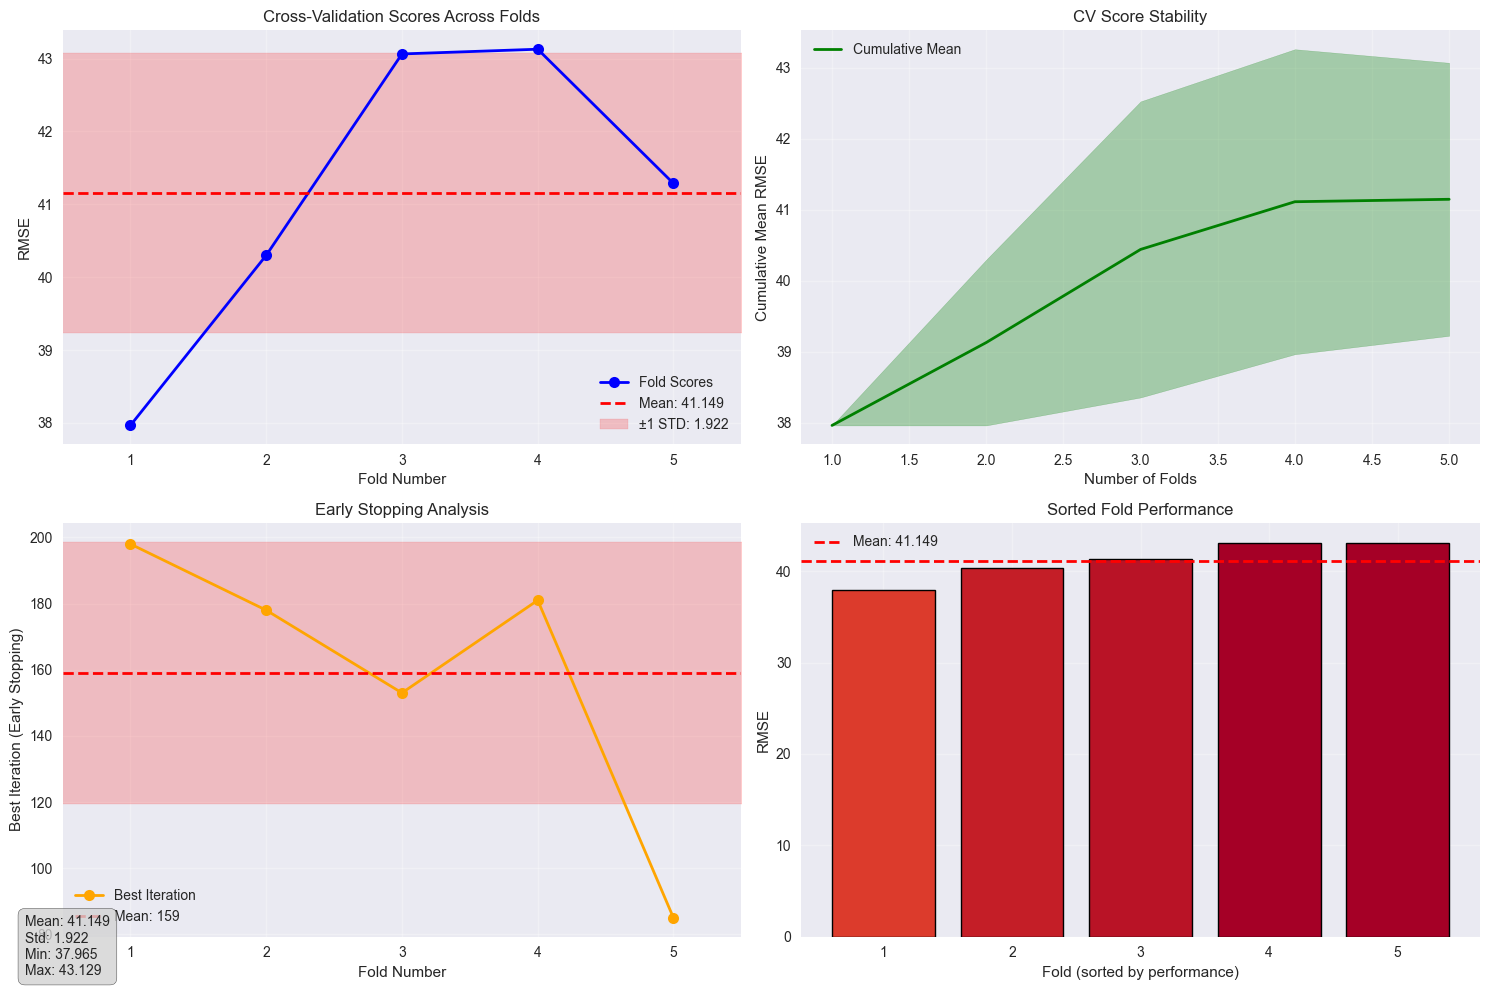

Creating training curve plots...


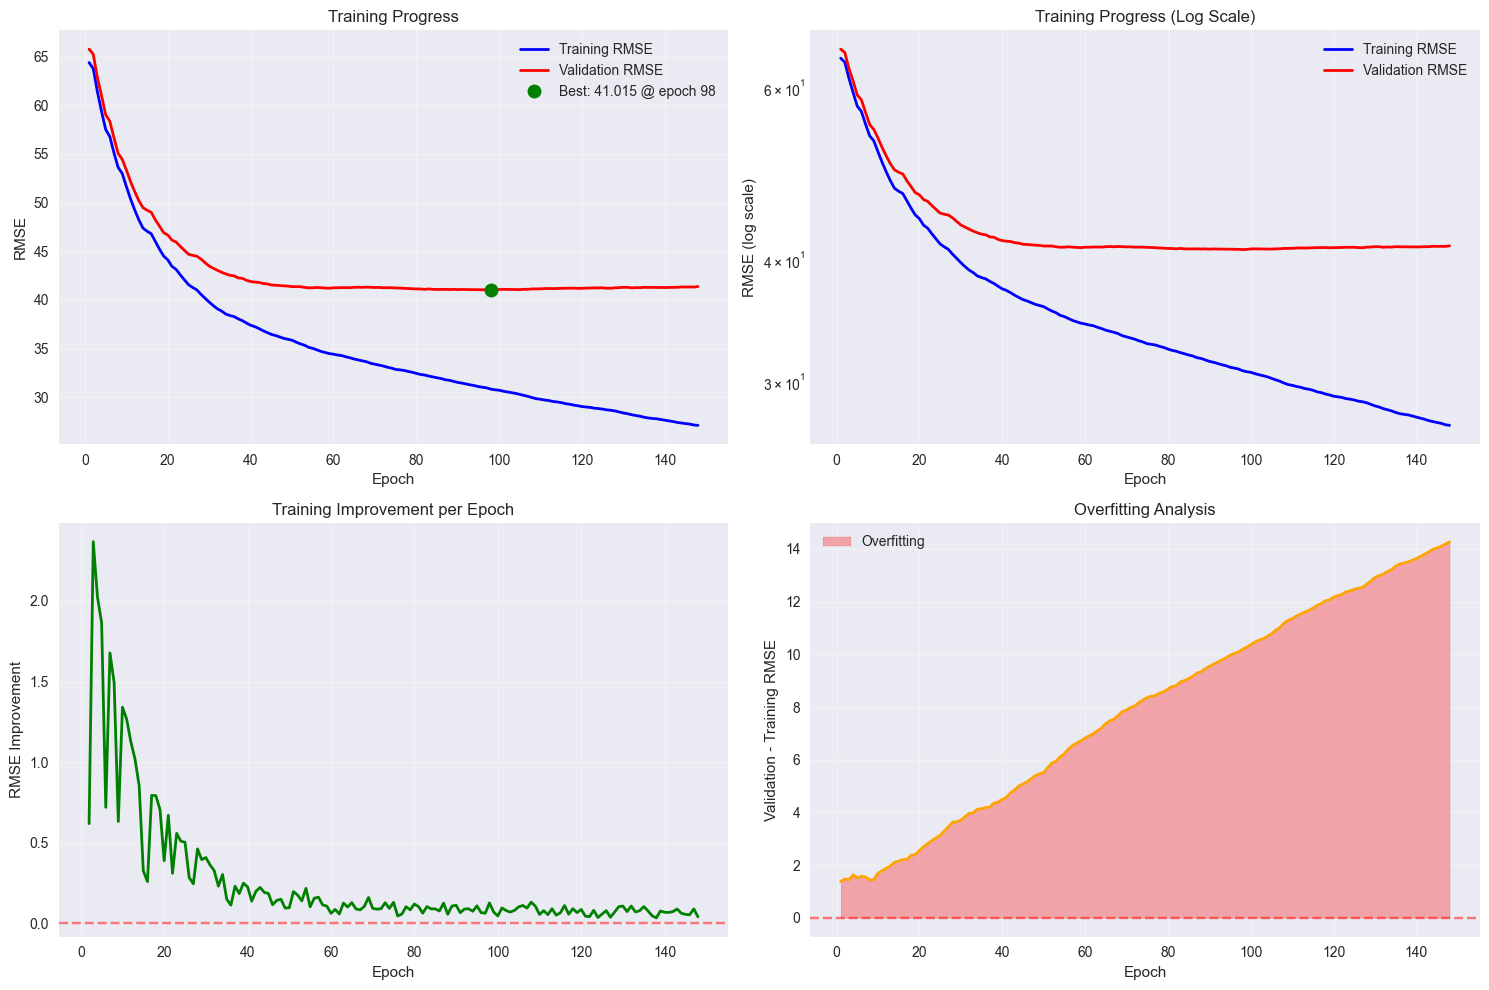


Training completed successfully!
Total time: 61.6s
Final test RMSE: 42.85 days
Advanced CV RMSE: 41.15 ± 1.92 days
Optuna optimization completed in 1.1m
Test RMSE: 42.85 days

RUNNING SCENARIOS FOR FEATURE SET: LEAKAGE_CONTROLLED
Features: 34

--- SCENARIO 1: Baseline_leakage_controlled ---
Purpose: Establish baseline with default XGBoost parameters
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_leakage_controlled_baseline_v3
Model directory: ../models\scdb_duration_leakage_controlled_baseline_v3
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 20 numerical and 12 categorical features
Fitting preprocessor...
Preprocessing complete: 68 features

Training final model with parameters:
  objective: reg:squarederror
  

  0%|          | 0/30 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 40.1128
Optuna study saved: ../models\scdb_duration_leakage_controlled_optuna_v3\scdb_duration_leakage_controlled_optuna_v3_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_leakage_controlled_optuna_v3\scdb_duration_leakage_controlled_optuna_v3_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 37.8109
  Fold 2/5 - RMSE: 39.8414
  Fold 3/5 - RMSE: 41.2041
  Fold 4/5 - RMSE: 43.7597
  Fold 5/5 - RMSE: 40.2918
Advanced CV RMSE: 40.58 ± 1.94
Average best iteration: 1573

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 2967
  learning_rate: 0.006458427994596644
  max_depth: 9
  subsample: 0.8
  colsample_bytree: 0.65
  gamma: 0.12142917223203617
  min_child_weight: 10
  reg_lambda: 0.22226694488325557
  reg_alp

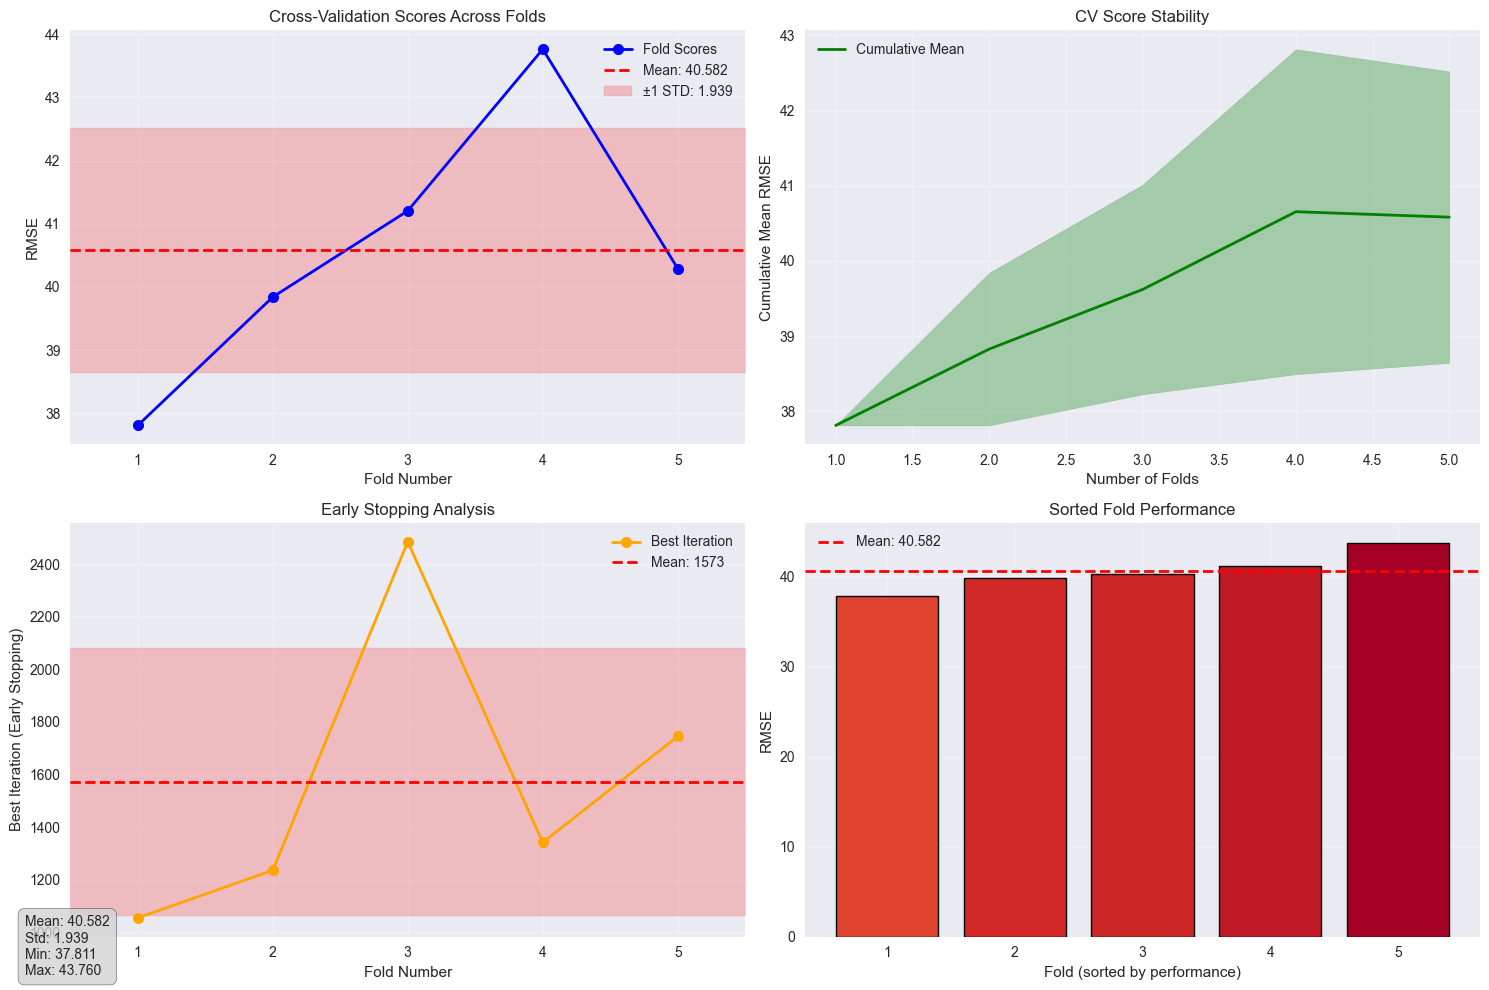

Creating training curve plots...


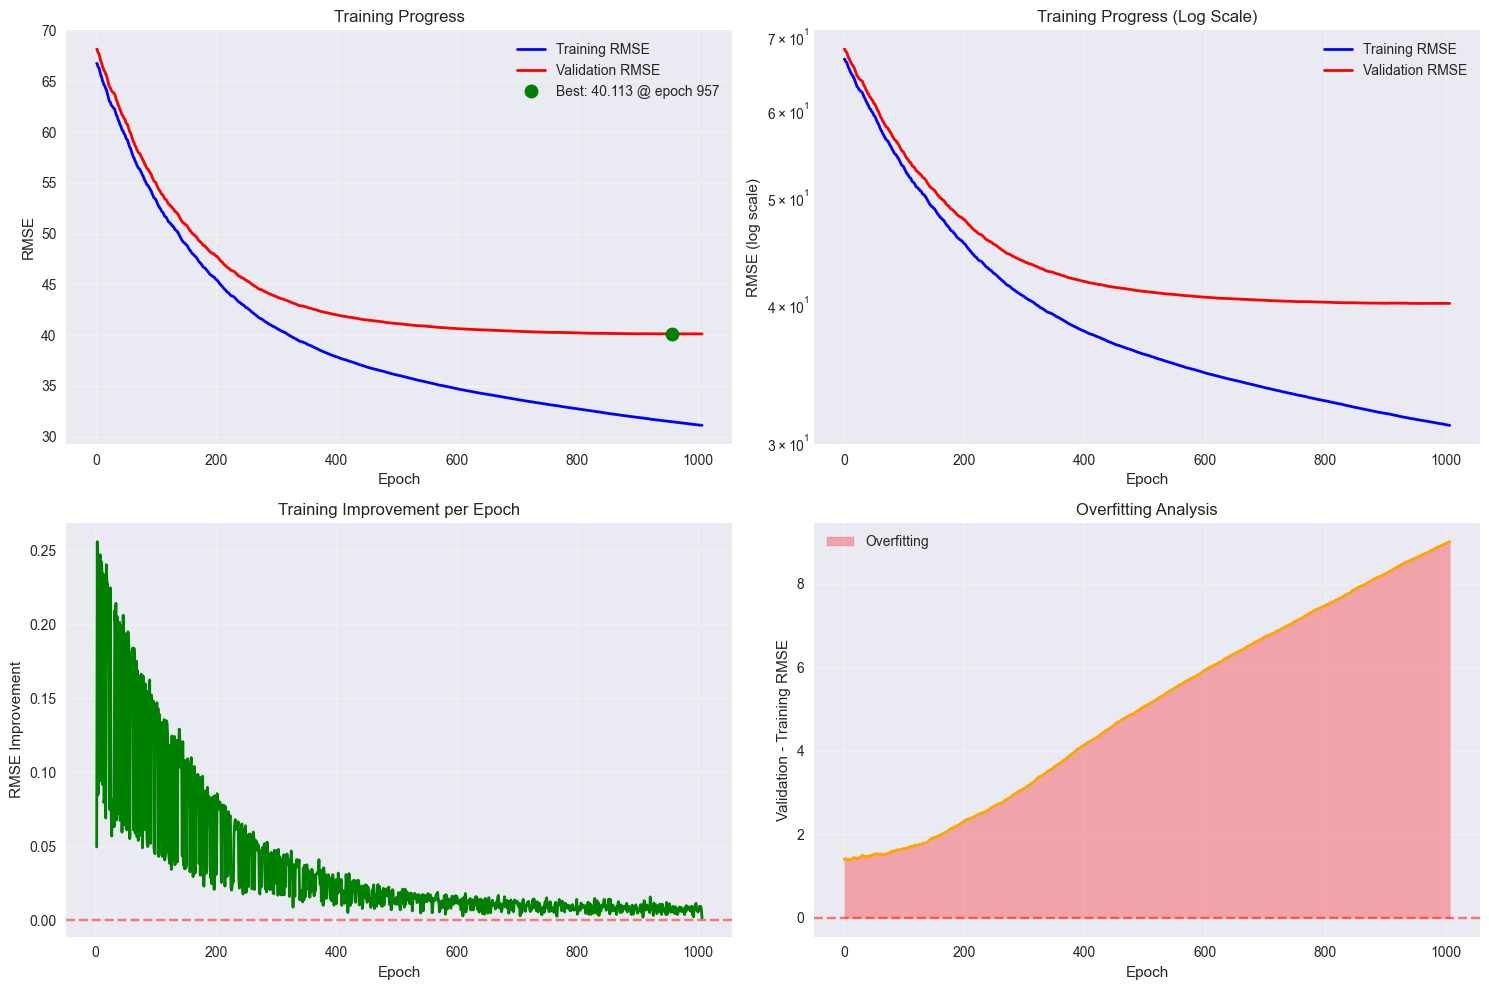


Training completed successfully!
Total time: 190.9s
Final test RMSE: 41.72 days
Advanced CV RMSE: 40.58 ± 1.94 days
Optuna optimization completed in 3.3m
Test RMSE: 41.72 days

RUNNING SCENARIOS FOR FEATURE SET: FULL_WITH_LEAKAGE
Features: 38

--- SCENARIO 1: Baseline_full_with_leakage ---
Purpose: Establish baseline with default XGBoost parameters
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_full_with_leakage_baseline_v3
Model directory: ../models\scdb_duration_full_with_leakage_baseline_v3
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 24 numerical and 12 categorical features
Fitting preprocessor...
Preprocessing complete: 72 features

Training final model with parameters:
  objective: reg:squarederror
  ran

  0%|          | 0/30 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 13.2283
Optuna study saved: ../models\scdb_duration_full_with_leakage_optuna_v3\scdb_duration_full_with_leakage_optuna_v3_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_full_with_leakage_optuna_v3\scdb_duration_full_with_leakage_optuna_v3_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 10.0084
  Fold 2/5 - RMSE: 10.6519
  Fold 3/5 - RMSE: 16.6203
  Fold 4/5 - RMSE: 18.6760
  Fold 5/5 - RMSE: 15.7214
Advanced CV RMSE: 14.34 ± 3.41
Average best iteration: 140

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 3507
  learning_rate: 0.05300623419439347
  max_depth: 10
  subsample: 0.75
  colsample_bytree: 0.95
  gamma: 0.14044213709932932
  min_child_weight: 11
  reg_lambda: 2.674576731984419
  reg_alpha: 0.

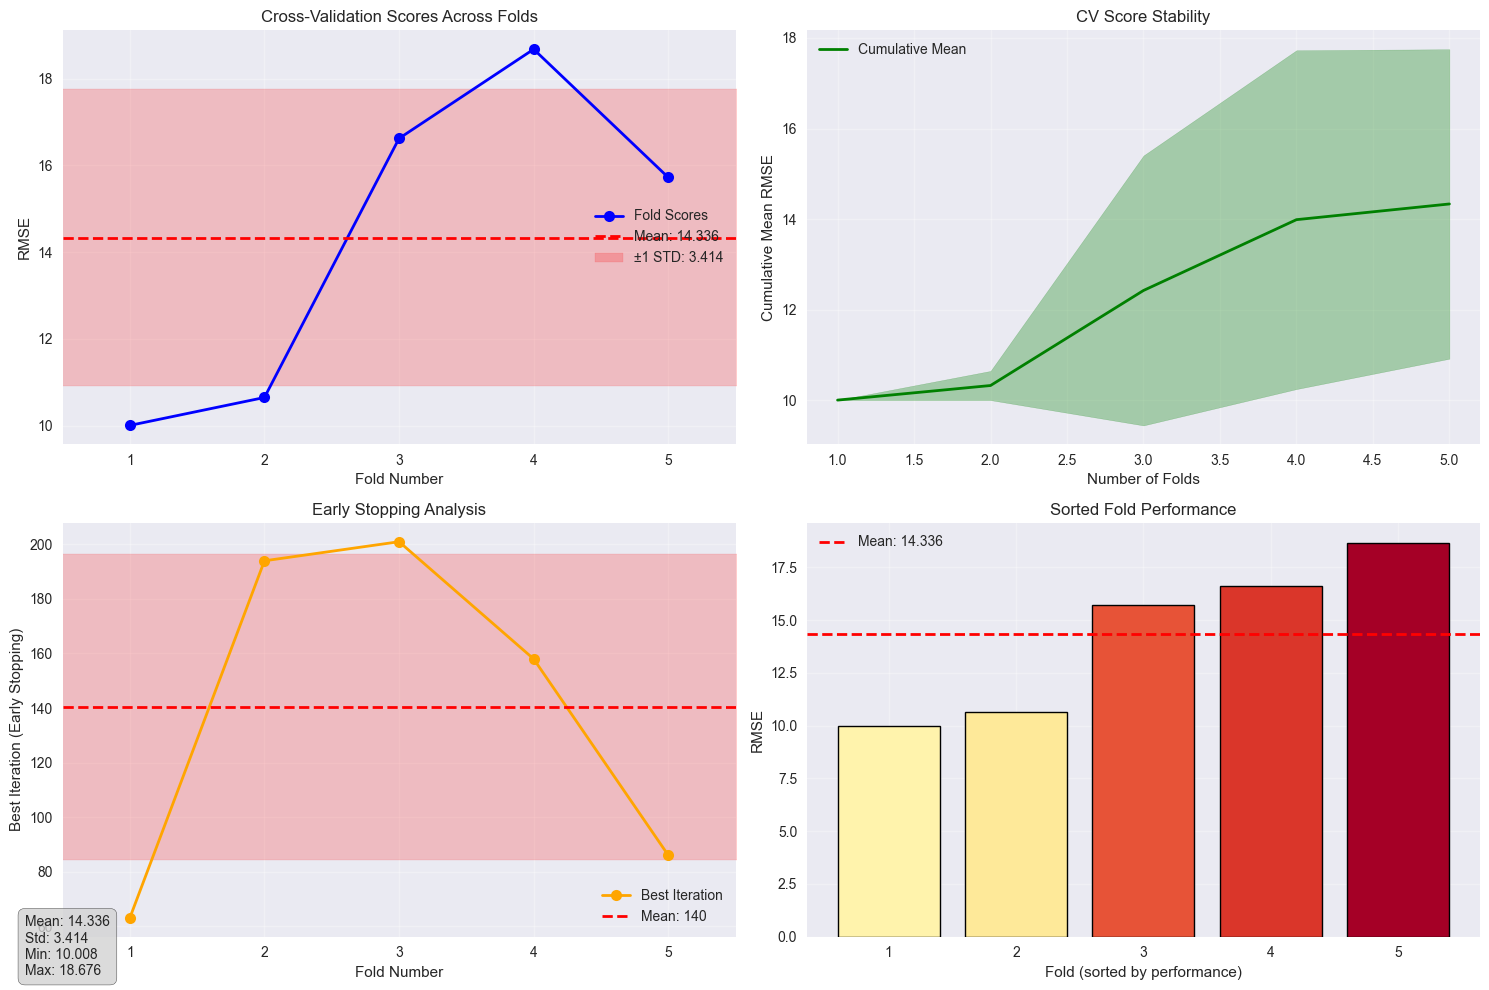

Creating training curve plots...


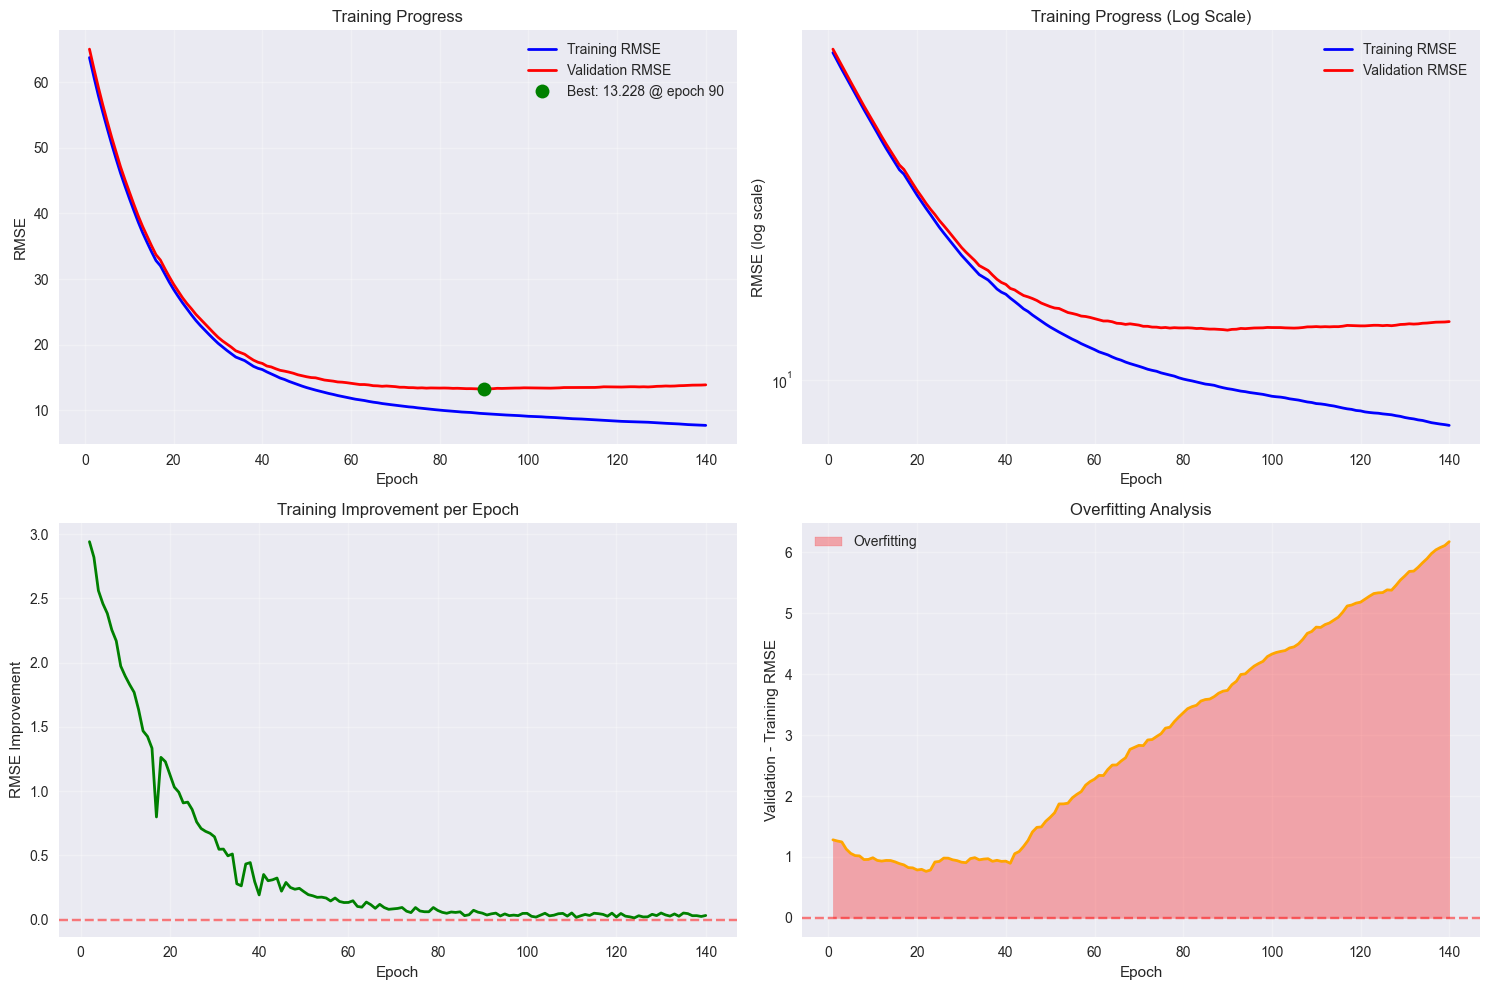


Training completed successfully!
Total time: 75.9s
Final test RMSE: 18.31 days
Advanced CV RMSE: 14.34 ± 3.41 days
Optuna optimization completed in 1.3m
Test RMSE: 18.31 days

LOG-TRANSFORMED TARGET EXPERIMENT

--- SCENARIO 4: LogTarget_Optuna_leakage_controlled ---
Purpose: Handle skewed target distribution with log transformation
Original target - Mean: 92.7, Std: 68.3
Log target - Mean: 4.33, Std: 0.67
Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_leakage_controlled_logtarget_v3
Model directory: ../models\scdb_duration_leakage_controlled_logtarget_v3
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 6196 samples (65.0%)
   Validation: 1431 samples (15.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 20 numerical and 12 categorical features
Fitting preprocessor...
Preprocessing complete: 68 features
Starting Opt

  0%|          | 0/30 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 0.4787
Optuna study saved: ../models\scdb_duration_leakage_controlled_logtarget_v3\scdb_duration_leakage_controlled_logtarget_v3_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_leakage_controlled_logtarget_v3\scdb_duration_leakage_controlled_logtarget_v3_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 0.4907
  Fold 2/5 - RMSE: 0.4814
  Fold 3/5 - RMSE: 0.4958
  Fold 4/5 - RMSE: 0.5009
  Fold 5/5 - RMSE: 0.4563
Advanced CV RMSE: 0.49 ± 0.02
Average best iteration: 913

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 1540
  learning_rate: 0.016017067169323645
  max_depth: 9
  subsample: 0.95
  colsample_bytree: 0.7
  gamma: 0.01172346324740703
  min_child_weight: 12
  reg_lambda: 0.5836377943625259
  reg_

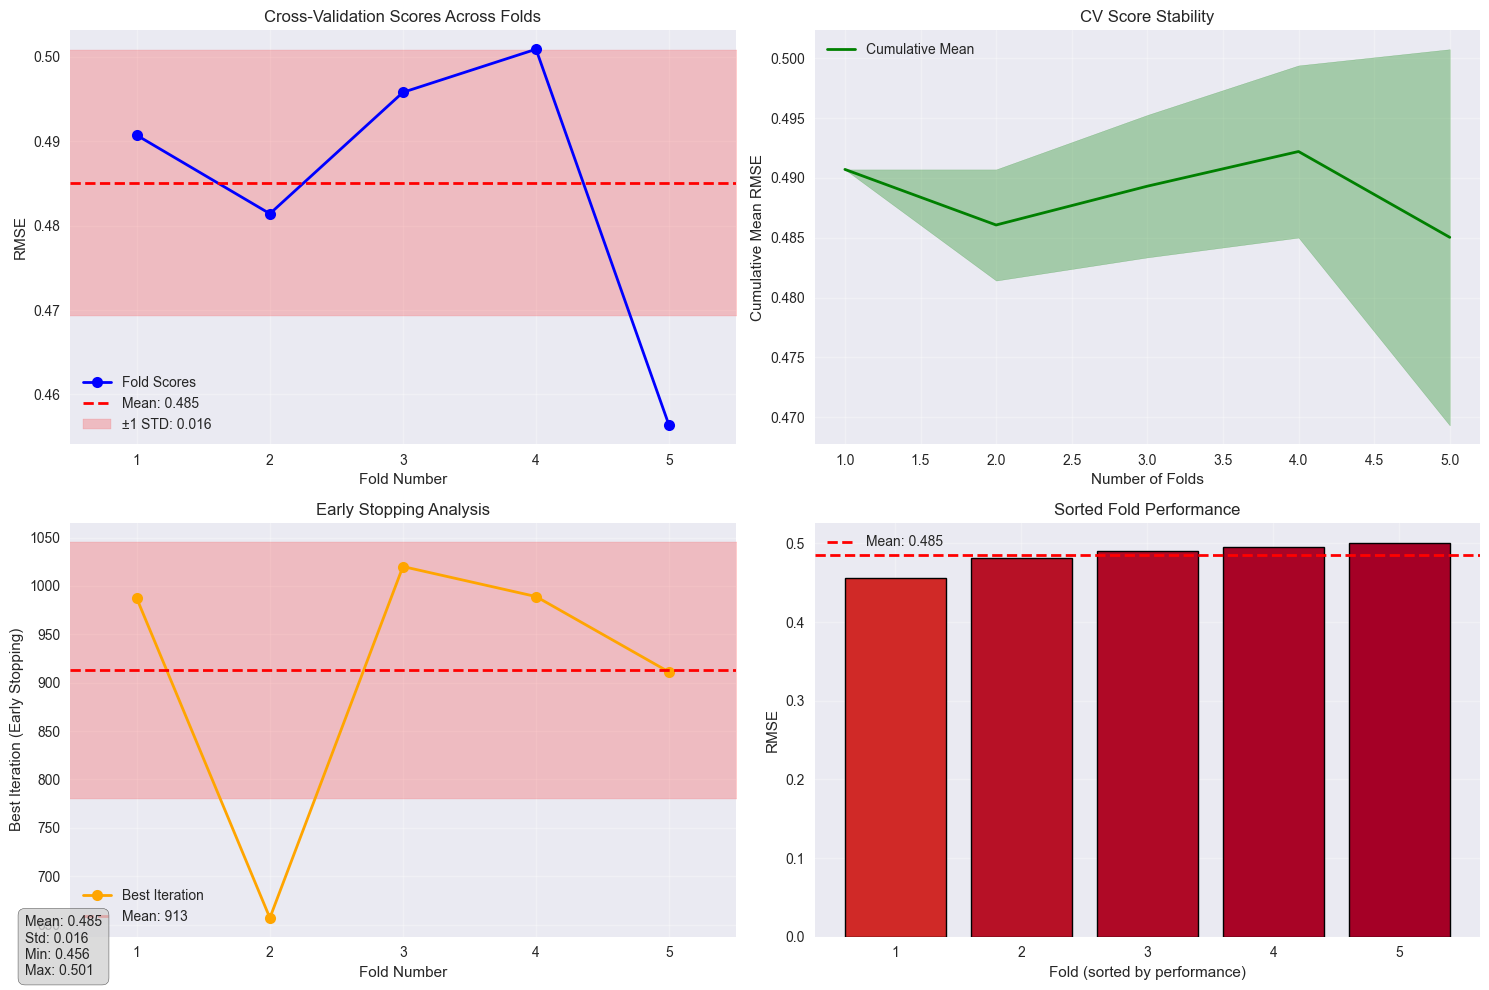

Creating training curve plots...


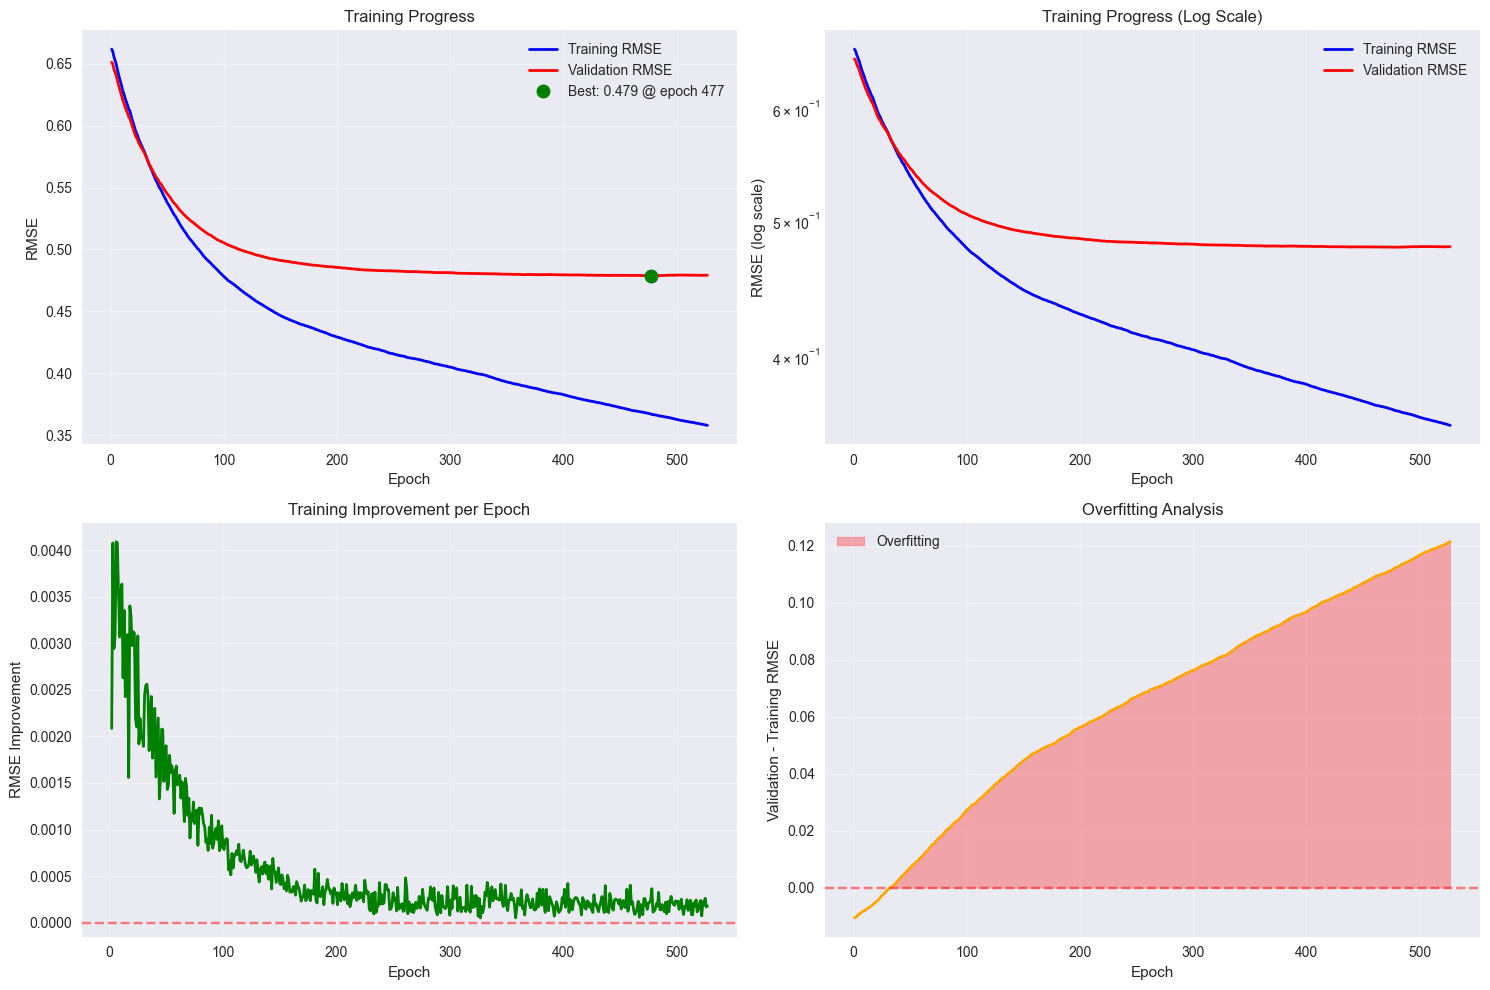


Training completed successfully!
Total time: 142.4s
Final test RMSE: 0.49 days
Advanced CV RMSE: 0.49 ± 0.02 days
Training completed in 146.4s
Test RMSE (original scale): 44.08 days

COMPILING AND COMPARING RESULTS

DETAILED MODEL COMPARISON:
                              Model  Train RMSE  Val RMSE  Test RMSE  Test MAE  Test R^2      CV RMSE  Training Time (s)  Features Used
           Optuna_full_with_leakage    9.494490 13.228262  18.313758  3.214084  0.936390 14.34 ± 3.41          80.046577             72
         Baseline_full_with_leakage    7.113210 15.028816  18.645035  4.452089  0.934068          N/A           2.300268             72
        Baseline_leakage_controlled   28.261248 40.424187  41.341303 27.879941  0.675857          N/A           3.132313             68
          Optuna_leakage_controlled   31.460960 40.112796  41.722901 28.386173  0.669846 40.58 ± 1.94         195.003287             68
                       Optuna_basic   30.828913 41.015257  42.845415 29.0972

In [35]:
# =============================================================================
# SECTION 1: SETUP AND IMPORTS
# =============================================================================
import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import time
import os
import re
from autogluon.tabular import TabularPredictor
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Set style for plots
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

# =============================================================================
# SECTION 2: FEATURE SET PREPARATION
# =============================================================================
print("="*80)
print("PREPARING FEATURE SETS FOR MODELING")
print("="*80)

# Prepare inputs for different feature sets
all_model_inputs = {}
if 'df_cleaned' in locals() and 'y' in locals() and \
   'numerical_features' in locals() and 'binary_features' in locals() and 'categorical_features' in locals() and \
   'basic_features_final' in locals() and 'leakage_controlled_features_final' in locals() and 'full_features_with_leakage_final' in locals():

    feature_sets_to_prepare = {
        "basic": basic_features_final,
        "leakage_controlled": leakage_controlled_features_final,
        "full_with_leakage": full_features_with_leakage_final
    }

    for set_name, selected_features_list in feature_sets_to_prepare.items():
        X_current = df_cleaned[selected_features_list]
        current_numerical = [f for f in numerical_features if f in X_current.columns]
        current_binary = [f for f in binary_features if f in X_current.columns]
        current_categorical = [f for f in categorical_features if f in X_current.columns]

        all_model_inputs[set_name] = {
            'X': X_current,
            'y': y,
            'numerical_for_trainer': current_numerical + current_binary,
            'categorical_for_trainer': current_categorical,
            'feature_list_name': set_name,
            'n_features': len(selected_features_list)
        }
        print(f"{set_name}: {len(selected_features_list)} features prepared")
else:
    print("Error: Prerequisite variables not defined. Please run preprocessing first.")
    all_model_inputs = {}

# =============================================================================
# SECTION 3: HYPERPARAMETER SEARCH SPACES
# =============================================================================
print("\n" + "="*80)
print("DEFINING HYPERPARAMETER SEARCH SPACES")
print("="*80)

# Define Optuna search spaces
optuna_search_space_xgb = {
    'n_estimators': {'type': 'int', 'low': 800, 'high': 4000},
    'learning_rate': {'type': 'float', 'low': 0.005, 'high': 0.1, 'log': True},
    'max_depth': {'type': 'int', 'low': 3, 'high': 10},
    'subsample': {'type': 'float', 'low': 0.6, 'high': 0.95, 'step': 0.05},
    'colsample_bytree': {'type': 'float', 'low': 0.6, 'high': 0.95, 'step': 0.05},
    'gamma': {'type': 'float', 'low': 0.01, 'high': 1, 'log': True},
    'min_child_weight': {'type': 'int', 'low': 5, 'high': 15},
    'reg_lambda': {'type': 'float', 'low': 0.1, 'high': 50.0, 'log': True},
    'reg_alpha': {'type': 'float', 'low': 0.01, 'high': 25.0, 'log': True},
}

# Constrained search space for random search
random_search_space = {
    'n_estimators': {'type': 'int', 'low': 500, 'high': 1500},
    'learning_rate': {'type': 'float', 'low': 0.02, 'high': 0.08},
    'max_depth': {'type': 'int', 'low': 5, 'high': 10},
    'subsample': {'type': 'float', 'low': 0.7, 'high': 0.9},
    'colsample_bytree': {'type': 'float', 'low': 0.7, 'high': 0.9},
}

print("Optuna search space defined")
print("Random search space defined (constrained)")

# Dictionary to store all results
all_scenario_results = {}

# =============================================================================
# SECTION 4: XGBOOST MODEL TRAINING (MULTIPLE SCENARIOS)
# =============================================================================
print("\n" + "="*80)
print("STARTING XGBOOST MODEL TRAINING")
print("="*80)

# Loop through feature sets
for set_name_key, inputs in all_model_inputs.items():
    print(f"\n" + "="*80)
    print(f"RUNNING SCENARIOS FOR FEATURE SET: {set_name_key.upper()}")
    print(f"Features: {inputs['n_features']}")
    print("="*80)

    current_X = inputs['X']
    current_y = inputs['y']
    current_num_for_trainer = inputs['numerical_for_trainer']
    current_cat_for_trainer = inputs['categorical_for_trainer']

    # -------------------------------------------------------------------------
    # SCENARIO 1: BASELINE MODEL
    # -------------------------------------------------------------------------
    scenario_model_name_1 = f'Baseline_{set_name_key}'
    print(f"\n--- SCENARIO 1: {scenario_model_name_1} ---")
    print("Purpose: Establish baseline with default XGBoost parameters")
    
    start_time = time.time()
    results_fs_baseline = trainer.train_model(
        X=current_X, y=current_y,
        numerical_features=current_num_for_trainer, 
        categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{set_name_key}_baseline',
        early_stopping_rounds=50, 
        create_plots=True, 
        perform_cv=False
    )
    run_time = time.time() - start_time
    
    if results_fs_baseline:
        results_fs_baseline['training_time'] = run_time
        print(f"Training completed in {run_time:.1f}s")
        if results_fs_baseline.get('metrics', {}).get('test'):
            print(f"Test RMSE: {results_fs_baseline['metrics']['test']['rmse']:.2f} days")
    all_scenario_results[scenario_model_name_1] = results_fs_baseline

    # # -------------------------------------------------------------------------
    # # SCENARIO 2: RANDOM SEARCH
    # # -------------------------------------------------------------------------
    # scenario_model_name_2 = f'RandomSearch_{set_name_key}'
    # print(f"\n--- SCENARIO 2: {scenario_model_name_2} ---")
    # print("Purpose: Hyperparameter optimization with RandomizedSearchCV")
    
    # random_search_config = {
    #     'n_iter': 30,  # Reduced iterations for faster execution
    #     'cv': 3        # 3-fold CV
    # }
    
    # start_time = time.time()
    # results_fs_random = trainer.train_model(
    #     X=current_X, y=current_y,
    #     numerical_features=current_num_for_trainer, 
    #     categorical_features=current_cat_for_trainer,
    #     model_name=f'scdb_duration_{set_name_key}_random',
    #     optimization_method='random',
    #     optimization_params=random_search_config,
    #     early_stopping_rounds=50,
    #     create_plots=True,
    #     perform_cv=False
    # )
    # run_time = time.time() - start_time
    
    # if results_fs_random:
    #     results_fs_random['training_time'] = run_time
    #     print(f"Random search completed in {run_time:.1f}s")
    #     if results_fs_random.get('metrics', {}).get('test'):
    #         print(f"Test RMSE: {results_fs_random['metrics']['test']['rmse']:.2f} days")
    # all_scenario_results[scenario_model_name_2] = results_fs_random

    # -------------------------------------------------------------------------
    # SCENARIO 3: OPTUNA OPTIMIZATION
    # -------------------------------------------------------------------------
    scenario_model_name_3 = f'Optuna_{set_name_key}'
    print(f"\n--- SCENARIO 3: {scenario_model_name_3} ---")
    print("Purpose: Advanced hyperparameter optimization with Optuna")
    
    start_time = time.time()
    results_fs_optuna = trainer.train_model(
        X=current_X, y=current_y,
        numerical_features=current_num_for_trainer, 
        categorical_features=current_cat_for_trainer,
        model_name=f'scdb_duration_{set_name_key}_optuna',
        optimization_method='optuna',
        optimization_params={
            'n_trials': 30, 
            'timeout': 1200, 
            'search_space': optuna_search_space_xgb.copy()
        },
        early_stopping_rounds=50, 
        create_plots=True,
        perform_cv=True, 
        cv_folds=5, 
        advanced_cv=True,
        plot_cv_results=True,
        plot_training_curves=True
    )
    run_time = time.time() - start_time
    
    if results_fs_optuna:
        results_fs_optuna['training_time'] = run_time
        print(f"Optuna optimization completed in {run_time/60:.1f}m")
        if results_fs_optuna.get('metrics', {}).get('test'):
            print(f"Test RMSE: {results_fs_optuna['metrics']['test']['rmse']:.2f} days")
    all_scenario_results[scenario_model_name_3] = results_fs_optuna

# =============================================================================
# SECTION 5: LOG-TRANSFORMED TARGET 
# =============================================================================
print("\n" + "="*80)
print("LOG-TRANSFORMED TARGET EXPERIMENT")
print("="*80)

# Only run on leakage_controlled feature set -> example of usage for one set
if 'leakage_controlled' in all_model_inputs:
    scenario_model_name_4 = f'LogTarget_Optuna_leakage_controlled'
    print(f"\n--- SCENARIO 4: {scenario_model_name_4} ---")
    print("Purpose: Handle skewed target distribution with log transformation")
    
    current_X = all_model_inputs['leakage_controlled']['X']
    current_y = all_model_inputs['leakage_controlled']['y']
    y_log_current = np.log1p(current_y)
    
    print(f"Original target - Mean: {current_y.mean():.1f}, Std: {current_y.std():.1f}")
    print(f"Log target - Mean: {y_log_current.mean():.2f}, Std: {y_log_current.std():.2f}")
    
    start_time = time.time()
    results_fs_log = trainer.train_model(
        X=current_X, y=y_log_current,
        numerical_features=all_model_inputs['leakage_controlled']['numerical_for_trainer'], 
        categorical_features=all_model_inputs['leakage_controlled']['categorical_for_trainer'],
        model_name=f'scdb_duration_leakage_controlled_logtarget',
        optimization_method='optuna',
        optimization_params={
            'n_trials': 30, 
            'timeout': 1200, 
            'search_space': optuna_search_space_xgb.copy()
        },
        early_stopping_rounds=50, 
        create_plots=True,
        perform_cv=True, 
        cv_folds=5, 
        advanced_cv=True,
        plot_cv_results=True,
        plot_training_curves=True
    )
    run_time = time.time() - start_time
    
    # Convert predictions back to original scale
    if results_fs_log:
        results_fs_log['training_time'] = run_time
        log_y_test_actual = results_fs_log.get('y_test')
        log_y_test_pred = results_fs_log.get('y_test_pred')
        if log_y_test_actual is not None and log_y_test_pred is not None:
            orig_y_test_actual = np.expm1(log_y_test_actual)
            orig_y_test_pred = np.expm1(log_y_test_pred)
            rmse_orig = np.sqrt(mean_squared_error(orig_y_test_actual, orig_y_test_pred))
            mae_orig = mean_absolute_error(orig_y_test_actual, orig_y_test_pred)
            r2_orig = r2_score(orig_y_test_actual, orig_y_test_pred)
            results_fs_log['metrics_original_scale'] = {
                'rmse': rmse_orig, 
                'mae': mae_orig, 
                'r2': r2_orig
            }
            print(f"Training completed in {run_time:.1f}s")
            print(f"Test RMSE (original scale): {rmse_orig:.2f} days")
    all_scenario_results[scenario_model_name_4] = results_fs_log

# # =============================================================================
# # SECTION 6: AUTOGLUON BENCHMARK -> for now commented out
# # =============================================================================
# print("\n" + "="*80)
# print("AUTOGLUON AUTOML BENCHMARK")
# print("="*80)

# scenario_model_name_5 = 'Autogluon_LeakageControlled'
# print(f"\n--- SCENARIO 5: {scenario_model_name_5} ---")
# print("Purpose: Benchmark against AutoML solution")

# if 'leakage_controlled' in all_model_inputs:
#     X_for_ag = all_model_inputs['leakage_controlled']['X'].copy()
#     y_for_ag = all_model_inputs['leakage_controlled']['y'].copy()
    
#     target_col_name = 'case_duration_days'
#     autogluon_data = X_for_ag.copy()
#     autogluon_data[target_col_name] = y_for_ag

#     # Use same random state for fair comparison
#     ag_train_df, ag_test_df = train_test_split(
#         autogluon_data, test_size=0.2, random_state=42
#     )
    
#     print(f"AutoGluon training data: {len(ag_train_df)} samples")
#     print(f"AutoGluon test data: {len(ag_test_df)} samples")
    
#     ag_save_path = '../models/autogluon_scdb_duration_leakage_controlled'
    
#     try:
#         autogluon_predictor = TabularPredictor(
#             label=target_col_name, 
#             path=ag_save_path,
#             problem_type='regression', 
#             eval_metric='rmse'
#         )
        
#         time_limit_ag = 240  # 4 minutes
#         start_time_ag = time.time()
#         autogluon_predictor.fit(
#             train_data=ag_train_df, 
#             presets='good_quality_faster_inference_only_refit',
#             time_limit=time_limit_ag
#         )
#         ag_train_time = time.time() - start_time_ag
#         print(f"AutoGluon training completed in {ag_train_time/60:.1f} minutes")

#         # Evaluate
#         ag_performance = autogluon_predictor.evaluate(ag_test_df)
#         ag_test_rmse = abs(ag_performance.get('rmse', np.nan))
#         ag_test_mae = abs(ag_performance.get('mae', np.nan))
#         ag_test_r2 = ag_performance.get('r2', np.nan)
        
#         print(f"AutoGluon Test RMSE: {ag_test_rmse:.2f} days")
        
#         # Get leaderboard
#         ag_leaderboard = autogluon_predictor.leaderboard(ag_test_df, silent=True)
#         best_model_info = ag_leaderboard.iloc[0]
        
#         all_scenario_results[scenario_model_name_5] = {
#             'metrics': {
#                 'train': {'rmse': np.nan, 'mae': np.nan},
#                 'validation': {'rmse': best_model_info['score_val'], 'mae': np.nan},
#                 'test': {'rmse': ag_test_rmse, 'mae': ag_test_mae, 'r2': ag_test_r2}
#             },
#             'model_name': f"AutoGluon_{best_model_info['model']}",
#             'training_time': ag_train_time,
#             'model_metadata': {
#                 'notes': 'AutoGluon on leakage_controlled features',
#                 'best_model': best_model_info['model'],
#                 'training_time': ag_train_time
#             }
#         }
#     except Exception as e:
#         print(f"AutoGluon failed: {e}")
#         all_scenario_results[scenario_model_name_5] = None

# =============================================================================
# SECTION 7: RESULTS COMPILATION AND COMPARISON
# =============================================================================
print("\n" + "="*80)
print("COMPILING AND COMPARING RESULTS")
print("="*80)

# Create comprehensive comparison dataframe
comparison_data = []
for name, results in all_scenario_results.items():
    if not results:
        continue
    
    model_entry = {'Model': name}
    metrics = results.get('metrics', {})
    
    # Training metrics
    train_metrics = metrics.get('train', {})
    val_metrics = metrics.get('validation', {})
    
    # Handle log-transformed metrics
    if 'metrics_original_scale' in results:
        test_metrics = results['metrics_original_scale']
    else:
        test_metrics = metrics.get('test', {})
    
    # Add all metrics
    model_entry['Train RMSE'] = train_metrics.get('rmse', np.nan)
    model_entry['Train MAE'] = train_metrics.get('mae', np.nan)
    model_entry['Val RMSE'] = val_metrics.get('rmse', np.nan)
    model_entry['Val MAE'] = val_metrics.get('mae', np.nan)
    model_entry['Test RMSE'] = test_metrics.get('rmse', np.nan)
    model_entry['Test MAE'] = test_metrics.get('mae', np.nan)
    model_entry['Test R^2'] = test_metrics.get('r2', np.nan)
    
    # Add CV results if available
    if 'cv_results' in results and results['cv_results']:
        cv_res = results['cv_results']
        model_entry['CV RMSE'] = f"{cv_res['cv_mean']:.2f} ± {cv_res['cv_std']:.2f}"
        model_entry['CV Folds'] = cv_res.get('cv_folds', 'N/A')
    else:
        model_entry['CV RMSE'] = 'N/A'
        model_entry['CV Folds'] = 'N/A'
    
    # Add training time
    model_entry['Training Time (s)'] = results.get('training_time', np.nan)
    
    # Add feature count
    if 'feature_names' in results:
        model_entry['Features Used'] = len(results['feature_names'])
    else:
        # Extract from model name
        if 'basic' in name.lower():
            model_entry['Features Used'] = all_model_inputs['basic']['n_features']
        elif 'leakage_controlled' in name.lower():
            model_entry['Features Used'] = all_model_inputs['leakage_controlled']['n_features']
        elif 'full' in name.lower():
            model_entry['Features Used'] = all_model_inputs['full_with_leakage']['n_features']
    
    # Add model path
    model_entry['Model Path'] = results.get('model_path', 'N/A')
    
    comparison_data.append(model_entry)

# Create and display comparison dataframe
comparison_df = pd.DataFrame(comparison_data)
comparison_df = comparison_df.sort_values('Test RMSE', ascending=True)

print("\nDETAILED MODEL COMPARISON:")
print("="*100)
display_cols = ['Model', 'Train RMSE', 'Val RMSE', 'Test RMSE', 'Test MAE', 'Test R^2', 'CV RMSE', 'Training Time (s)', 'Features Used']
print(comparison_df[display_cols].to_string(index=False))

# =============================================================================
# SECTION 8: SAVE RESULTS AND IDENTIFY BEST MODELS
# =============================================================================
print("\n" + "="*80)
print("SAVING RESULTS AND IDENTIFYING BEST MODELS")
print("="*80)

# Save detailed results
output_csv_path = '../data/model_results/model_comparison_detailed.csv'
os.makedirs(os.path.dirname(output_csv_path), exist_ok=True)
comparison_df.to_csv(output_csv_path, index=False)
print(f"Detailed results saved to '{output_csv_path}'")

# Identify best models
if len(comparison_df) > 0:
    # Best overall
    best_overall = comparison_df.iloc[0]
    print(f"\n BEST OVERALL MODEL: {best_overall['Model']}")
    print(f"   Test RMSE: {best_overall['Test RMSE']:.2f} days")
    print(f"   Test MAE: {best_overall['Test MAE']:.2f} days")
    print(f"   Test R^2: {best_overall['Test R^2']:.4f}")
    print(f"   Training Time: {best_overall['Training Time (s)']:.1f}s")
    
    # Best without leakage
    no_leakage_df = comparison_df[~comparison_df['Model'].str.contains('full_with_leakage')]
    if len(no_leakage_df) > 0:
        best_no_leakage = no_leakage_df.iloc[0]
        print(f"\n BEST MODEL WITHOUT LEAKAGE: {best_no_leakage['Model']}")
        print(f"   Test RMSE: {best_no_leakage['Test RMSE']:.2f} days")
        print(f"   Model Path: {best_no_leakage['Model Path']}")
    
    # Store best model paths for later use
    best_models = {
        'best_overall': {
            'name': best_overall['Model'],
            'path': best_overall['Model Path'],
            'rmse': best_overall['Test RMSE']
        },
        'best_no_leakage': {
            'name': best_no_leakage['Model'],
            'path': best_no_leakage['Model Path'],
            'rmse': best_no_leakage['Test RMSE']
        } if len(no_leakage_df) > 0 else None
    }
    
    # Save best models info
    import json
    with open('../data/model_results/best_models_info.json', 'w') as f:
        json.dump(best_models, f, indent=2)
    print("\n Best models information saved for further analysis")

another try

In [40]:
# More conservative Optuna search space to combat overfitting
optuna_search_space_regularized = {
    'n_estimators': {'type': 'int', 'low': 100, 'high': 1000},  # Reduced from 800-4000
    'learning_rate': {'type': 'float', 'low': 0.01, 'high': 0.1, 'log': True},  # Increased minimum
    'max_depth': {'type': 'int', 'low': 3, 'high': 8},  # Reduced from 3-14
    'subsample': {'type': 'float', 'low': 0.5, 'high': 0.8, 'step': 0.05},  # More aggressive subsampling
    'colsample_bytree': {'type': 'float', 'low': 0.5, 'high': 0.8, 'step': 0.05},  # More aggressive
    'gamma': {'type': 'float', 'low': 0.1, 'high': 5.0, 'log': True},  # Increased for more pruning
    'min_child_weight': {'type': 'int', 'low': 5, 'high': 20},  # Increased from 3-15
    'reg_lambda': {'type': 'float', 'low': 1.0, 'high': 100.0, 'log': True},  # Stronger L2
    'reg_alpha': {'type': 'float', 'low': 0.1, 'high': 50.0, 'log': True},  # Stronger L1
}

Starting Enhanced XGBoost Training Pipeline
Device: CUDA
Model name: scdb_duration_basic_optuna_v3
Model directory: ../models\scdb_duration_basic_optuna_v3
Creating data splits...
Using stratified sampling based on duration bins.
Data splits created:
   Train: 5720 samples (60.0%)
   Validation: 1907 samples (20.0%)
   Test: 1907 samples (20.0%)
   Total: 9534 samples (sum: 100.0%)
Creating preprocessing pipeline...
Preprocessor created for 20 numerical and 12 categorical features
Fitting preprocessor...
Preprocessing complete: 68 features
Starting Optuna optimization with 100 trials (max 1200s)...
Using custom search space provided from the notebook.


  0%|          | 0/100 [00:00<?, ?it/s]

Optuna optimization completed! Best RMSE: 39.9940
Optuna study saved: ../models\scdb_duration_basic_optuna_v3\scdb_duration_basic_optuna_v3_optuna_study.joblib
Optuna database saved: ../models\scdb_duration_basic_optuna_v3\scdb_duration_basic_optuna_v3_optuna.db

Performing 5-fold cross-validation...
Performing advanced 5-fold cross-validation with early stopping support...
  Fold 1/5 - RMSE: 37.6413
  Fold 2/5 - RMSE: 40.0448
  Fold 3/5 - RMSE: 41.8596
  Fold 4/5 - RMSE: 43.5351
  Fold 5/5 - RMSE: 40.0909
Advanced CV RMSE: 40.63 ± 1.98
Average best iteration: 251

Training final model with parameters:
  objective: reg:squarederror
  random_state: 420
  n_jobs: -1
  tree_method: gpu_hist
  gpu_id: 0
  predictor: gpu_predictor
  n_estimators: 253
  learning_rate: 0.0321925246277005
  max_depth: 8
  subsample: 0.65
  colsample_bytree: 0.65
  gamma: 0.18709023829108465
  min_child_weight: 5
  reg_lambda: 1.3940902668257946
  reg_alpha: 8.014630436026504
  early_stopping_rounds: 100

Train

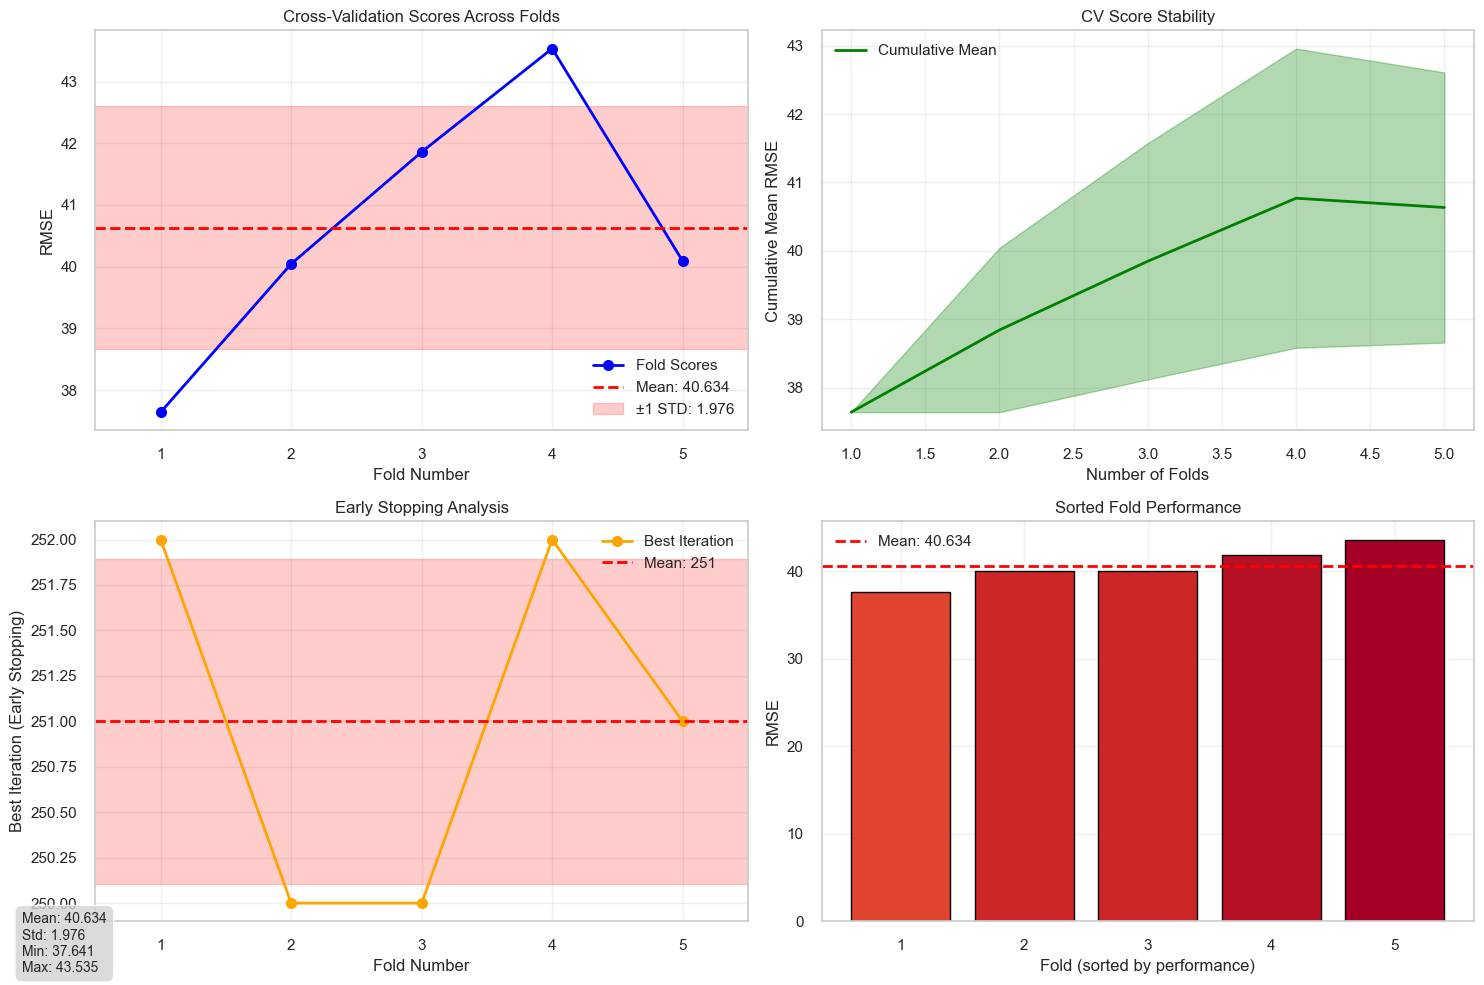

Creating training curve plots...


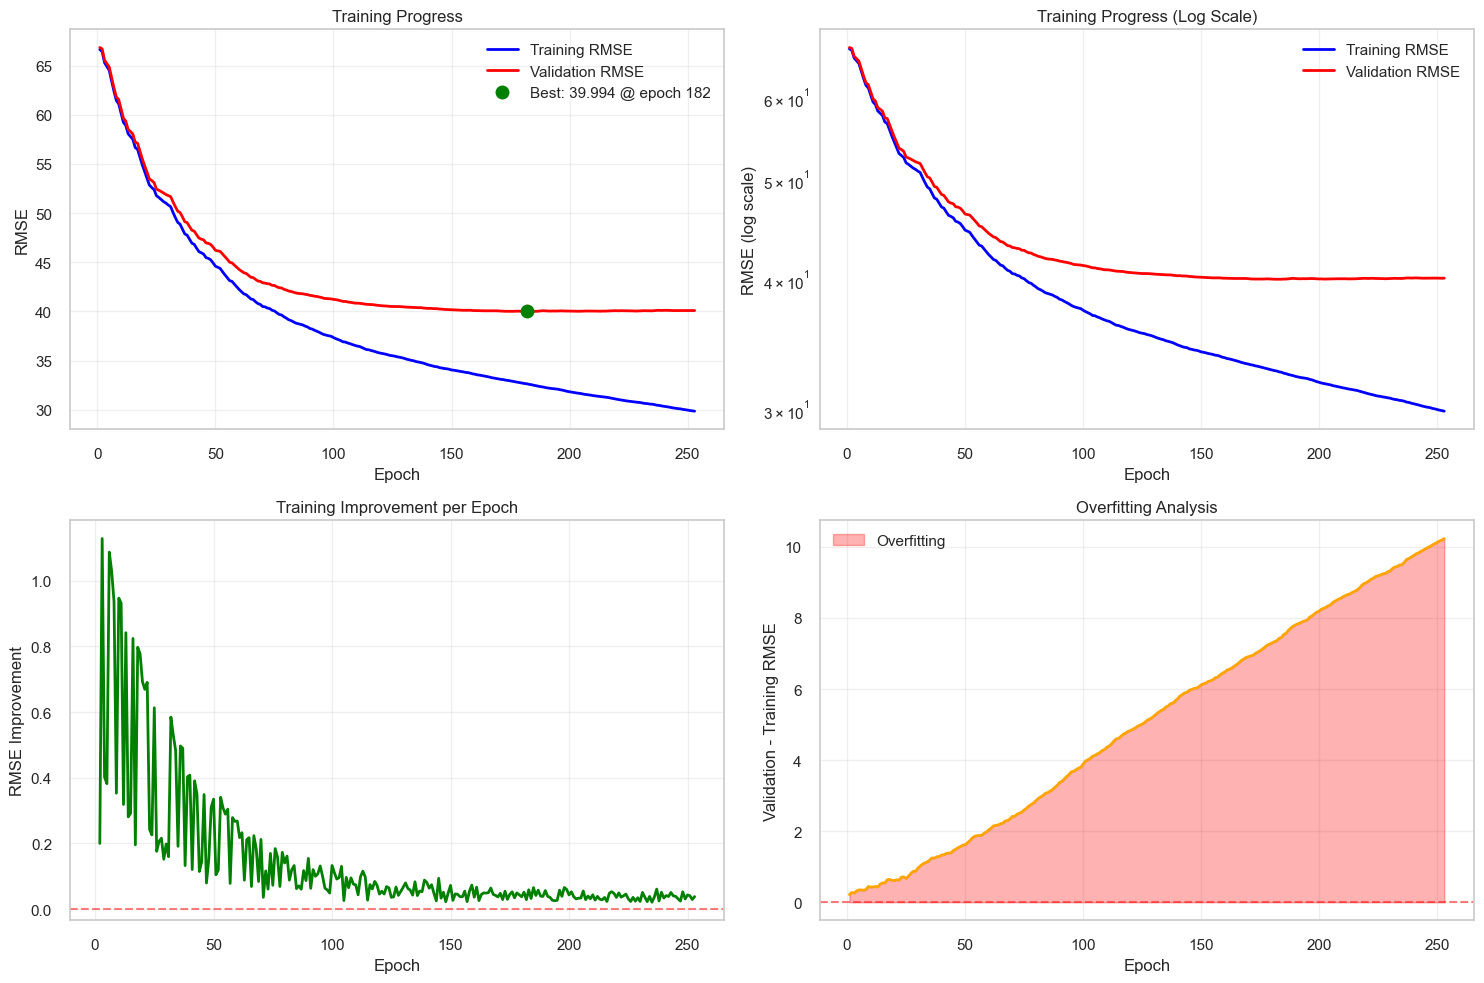


Training completed successfully!
Total time: 174.6s
Final test RMSE: 41.94 days
Advanced CV RMSE: 40.63 ± 1.98 days


In [129]:
results_fs_optuna = trainer.train_model(
    X=current_X, y=current_y,
    numerical_features=current_num_for_trainer, 
    categorical_features=current_cat_for_trainer,
    model_name=f'scdb_duration_{set_name_key}_optuna',
    optimization_method='optuna',
    optimization_params={
        'n_trials': 100, 
        'timeout': 1200, 
        'search_space': optuna_search_space_regularized  # Use the regularized space
    },
    early_stopping_rounds=100,  # Increase from 50
    create_plots=True,
    perform_cv=True, 
    cv_folds=5, 
    advanced_cv=True,
    plot_cv_results=True,
    plot_training_curves=True,
    eval_size=0.2  # Increase validation size
)

In [ ]:
# Loop through feature sets
for set_name_key, inputs in all_model_inputs.items():
    print(f"\n" + "="*80)
    print(f"RUNNING SCENARIOS FOR FEATURE SET: {set_name_key.upper()}")
    print(f"Features: {inputs['n_features']}")
    print("="*80)

    current_X = inputs['X']
    current_y = inputs['y']
    current_num_for_trainer = inputs['numerical_for_trainer']
    current_cat_for_trainer = inputs['categorical_for_trainer']

    print(f"Numerical features for trainer ({set_name_key}): {current_num_for_trainer}")
    print(f"Categorical features for trainer ({set_name_key}): {current_cat_for_trainer}")


RUNNING SCENARIOS FOR FEATURE SET: BASIC
Features: 14
Numerical features for trainer (basic): ['month_of_argument', 'days_term_start_to_argument', 'natural_court_period', 'court_term_year', 'lower_court_disagreement', 'consolidated_dockets_count', 'is_argument_late_in_term']
Categorical features for trainer (basic): ['case_docket_type', 'jurisdiction_type', 'broad_issue_area', 'petitioner_type', 'respondent_type', 'lower_court_disposition_type', 'chief_justice_sname']

RUNNING SCENARIOS FOR FEATURE SET: LEAKAGE_CONTROLLED
Features: 34
Numerical features for trainer (leakage_controlled): ['month_of_argument', 'days_term_start_to_argument', 'natural_court_period', 'court_term_year', 'lower_court_disagreement', 'consolidated_dockets_count', 'complexity_score_consolidated_disagree', 'three_judge_district_court', 'arg_month_cos', 'arg_month_sin', 'is_argument_late_in_term', 'is_govt_vs_business_case', 'is_individual_vs_govt_case', 'is_state_vs_state_case', 'is_admin_economic_case', 'is_fed

In [43]:
model_paths = [
    '../models/scdb_duration_basic_optuna_v1/scdb_duration_basic_optuna_v1.joblib',
    '../models/scdb_duration_leakage_controlled_optuna_v1/scdb_duration_leakage_controlled_optuna_v1.joblib'
]

# Create ensemble predictions
ensemble_pred = trainer.create_ensemble_predictions(model_paths, current_X)

# Evaluate
ensemble_metrics = trainer.evaluate_ensemble(current_Y, ensemble_pred)

Loaded model 1/2: scdb_duration_basic_optuna_v1.joblib
Loaded model 2/2: scdb_duration_leakage_controlled_optuna_v1.joblib
Created simple average ensemble


NameError: name 'current_Y' is not defined

## 6. Handling the model outputs

Results Comparison: Create a summary table (e.g., a pandas DataFrame) from the all_results dictionary to compare the Test RMSE, MAE, and R^2 across all feature sets and scenarios. 


--- Loading original dataset ---
Using pre-loaded df_cleaned and y.

Found 22 models:
  [0] scdb_duration_leakage_controlled_logtarget_v1 (RMSE: 0.48)
  [1] scdb_duration_leakage_controlled_logtarget_v2 (RMSE: 0.49)
  [2] scdb_duration_leakage_controlled_logtarget_v3 (RMSE: 0.49)
  [3] scdb_duration_full_with_leakage_optuna_v2 (RMSE: 17.74)
  [4] scdb_duration_full_with_leakage_optuna_v3 (RMSE: 18.31)
  [5] scdb_duration_full_with_leakage_optuna_v1 (RMSE: 18.43)
  [6] scdb_duration_full_with_leakage_baseline_v3 (RMSE: 18.65)
  [7] scdb_duration_full_with_leakage_baseline_v2 (RMSE: 18.65)
  [8] scdb_duration_full_with_leakage_baseline_v1 (RMSE: 18.91)
  [9] scdb_duration_leakage_controlled_optuna_v1 (RMSE: 40.94)
  [10] scdb_duration_leakage_controlled_optuna_v2 (RMSE: 41.05)
  [11] scdb_duration_leakage_controlled_baseline_v3 (RMSE: 41.34)
  [12] scdb_duration_leakage_controlled_baseline_v2 (RMSE: 41.34)
  [13] scdb_duration_leakage_controlled_optuna_v3 (RMSE: 41.72)
  [14] scdb_durat

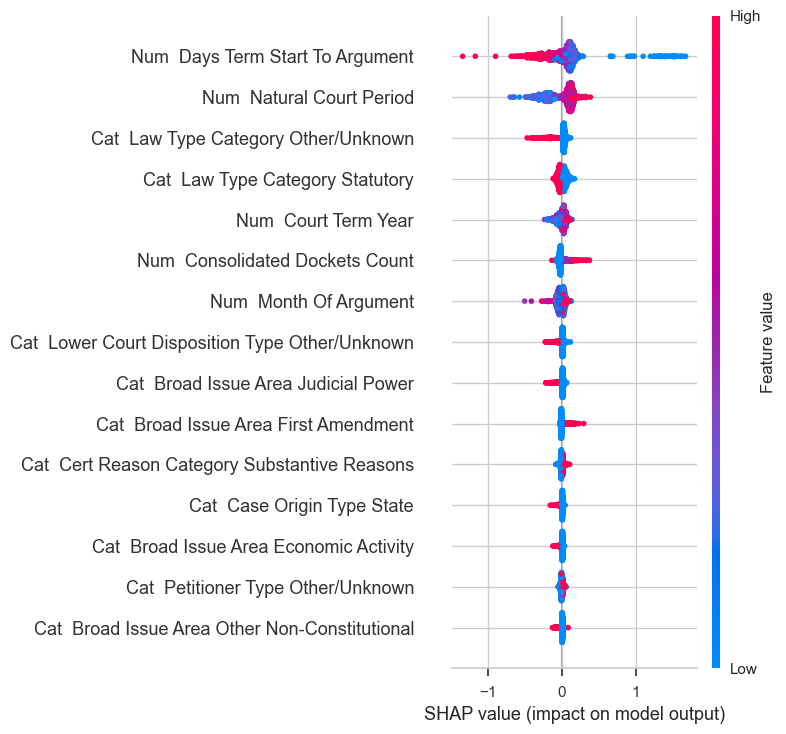

  SHAP plots saved successfully

3. Generating Partial Dependence Plots...

Generating Partial Dependence Plots...
  Could not create PDP for jurisdiction_type: can't multiply sequence by non-int of type 'float'
  Could not create PDP for case_origin_type: can't multiply sequence by non-int of type 'float'
  Could not create PDP for broad_issue_area: can't multiply sequence by non-int of type 'float'
  Could not create PDP for law_type_category: can't multiply sequence by non-int of type 'float'
  Could not create PDP for case_source_type: can't multiply sequence by non-int of type 'float'


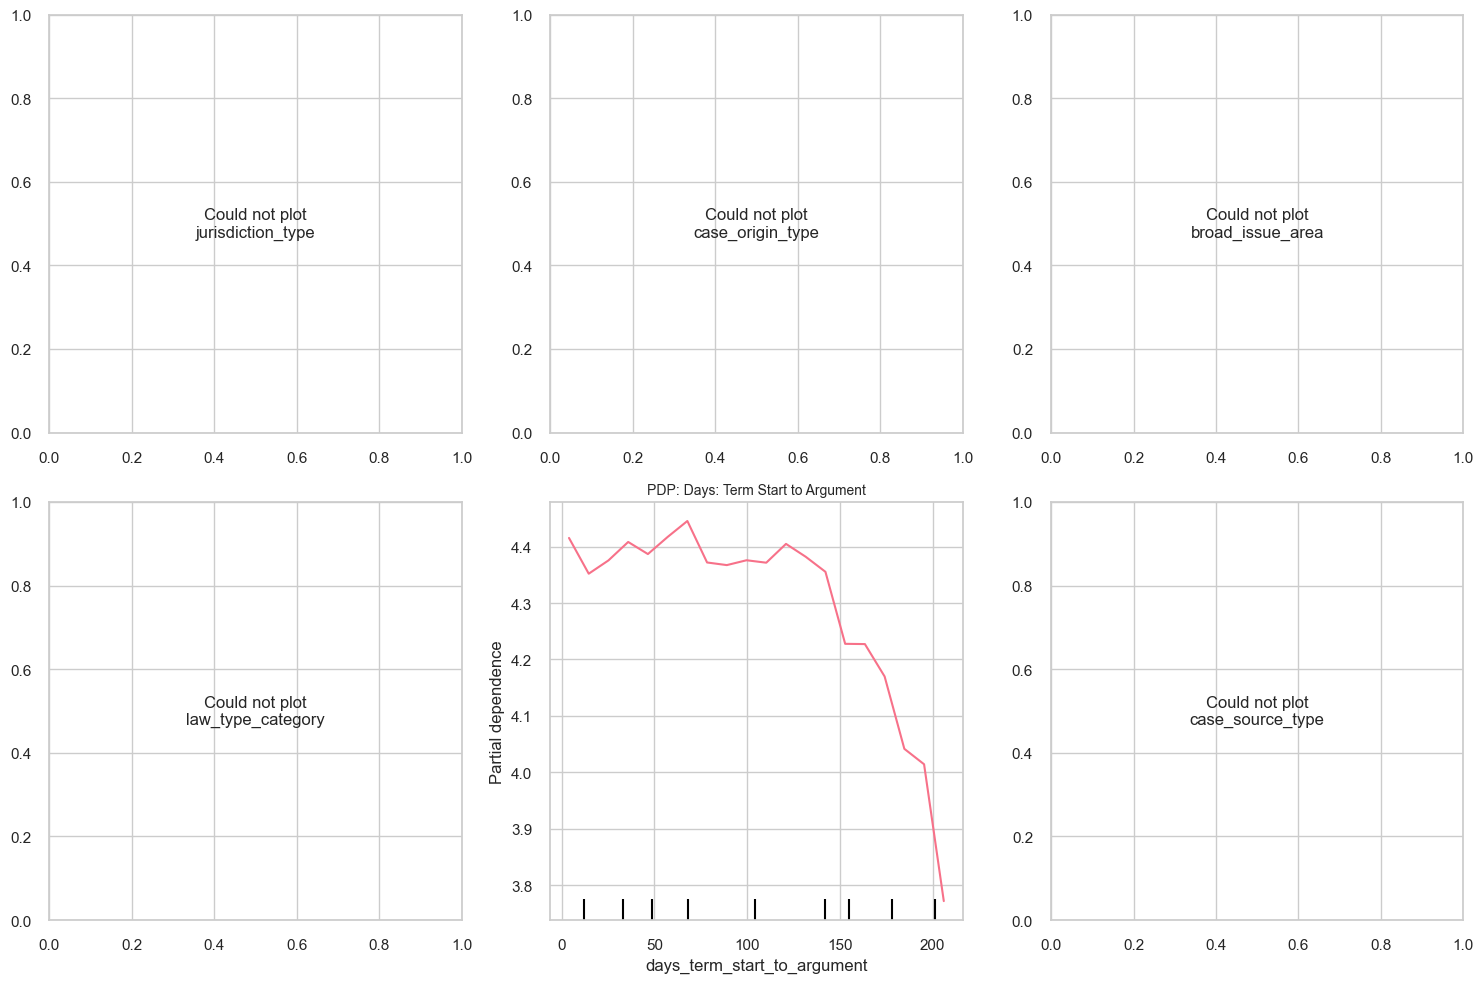

  PDP plots saved successfully

4. Generating ICE Plots...

Generating ICE Plots...
  Could not create ICE for jurisdiction_type: can't multiply sequence by non-int of type 'float'
  Could not create ICE for case_origin_type: can't multiply sequence by non-int of type 'float'
  Could not create ICE for broad_issue_area: can't multiply sequence by non-int of type 'float'
  Could not create ICE for law_type_category: can't multiply sequence by non-int of type 'float'


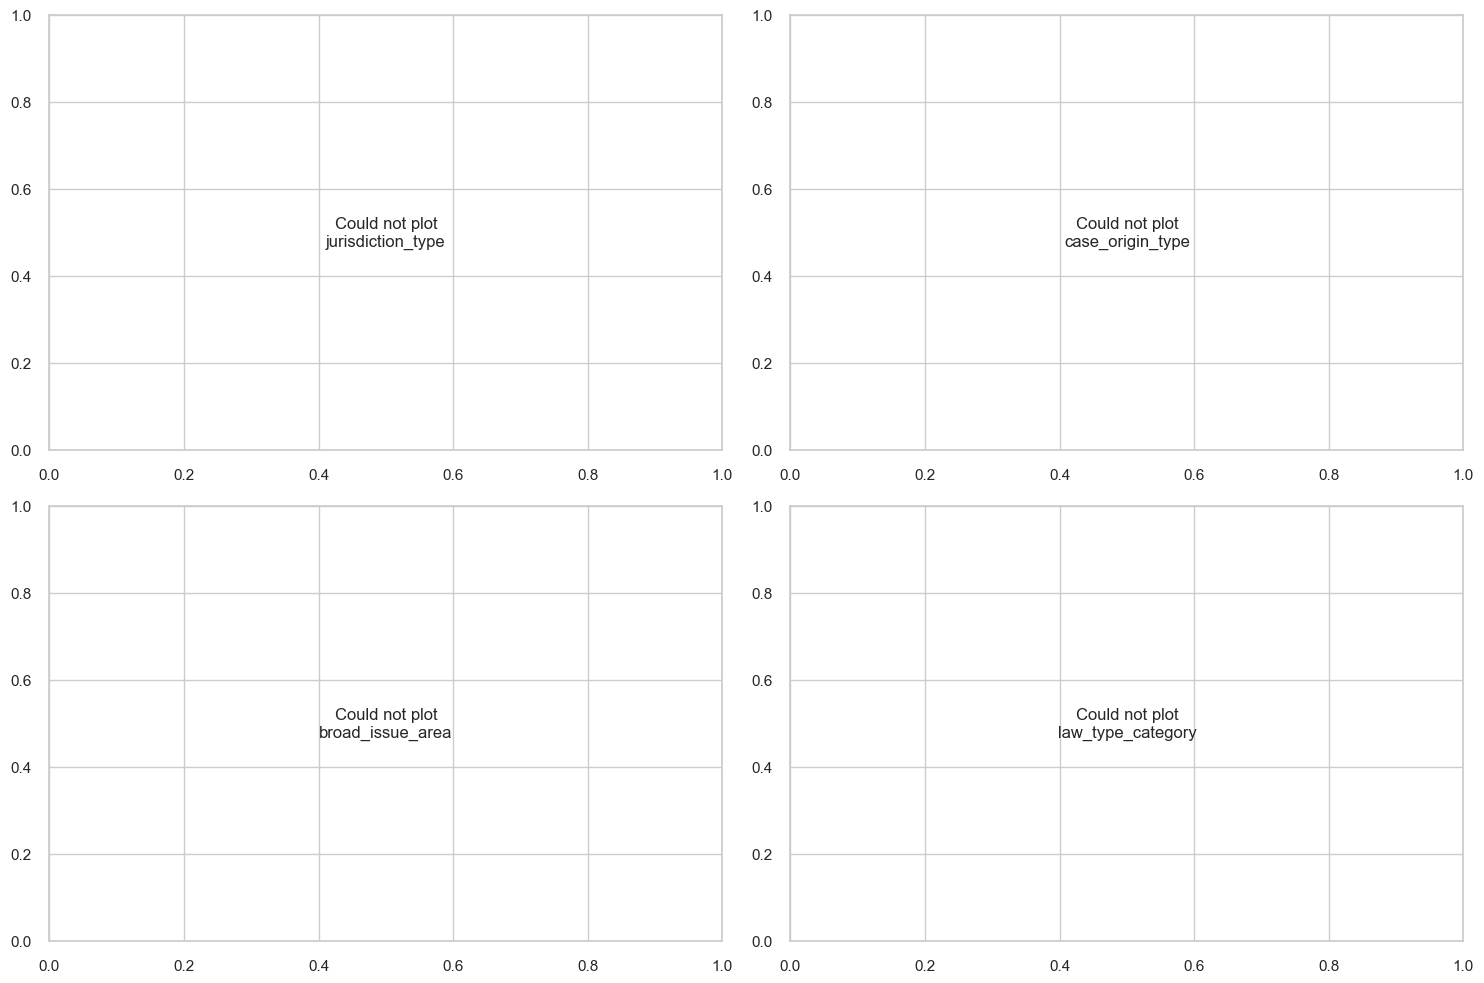

  ICE plots saved successfully

5. Generating Error Analysis...

Generating Error Analysis Plots...


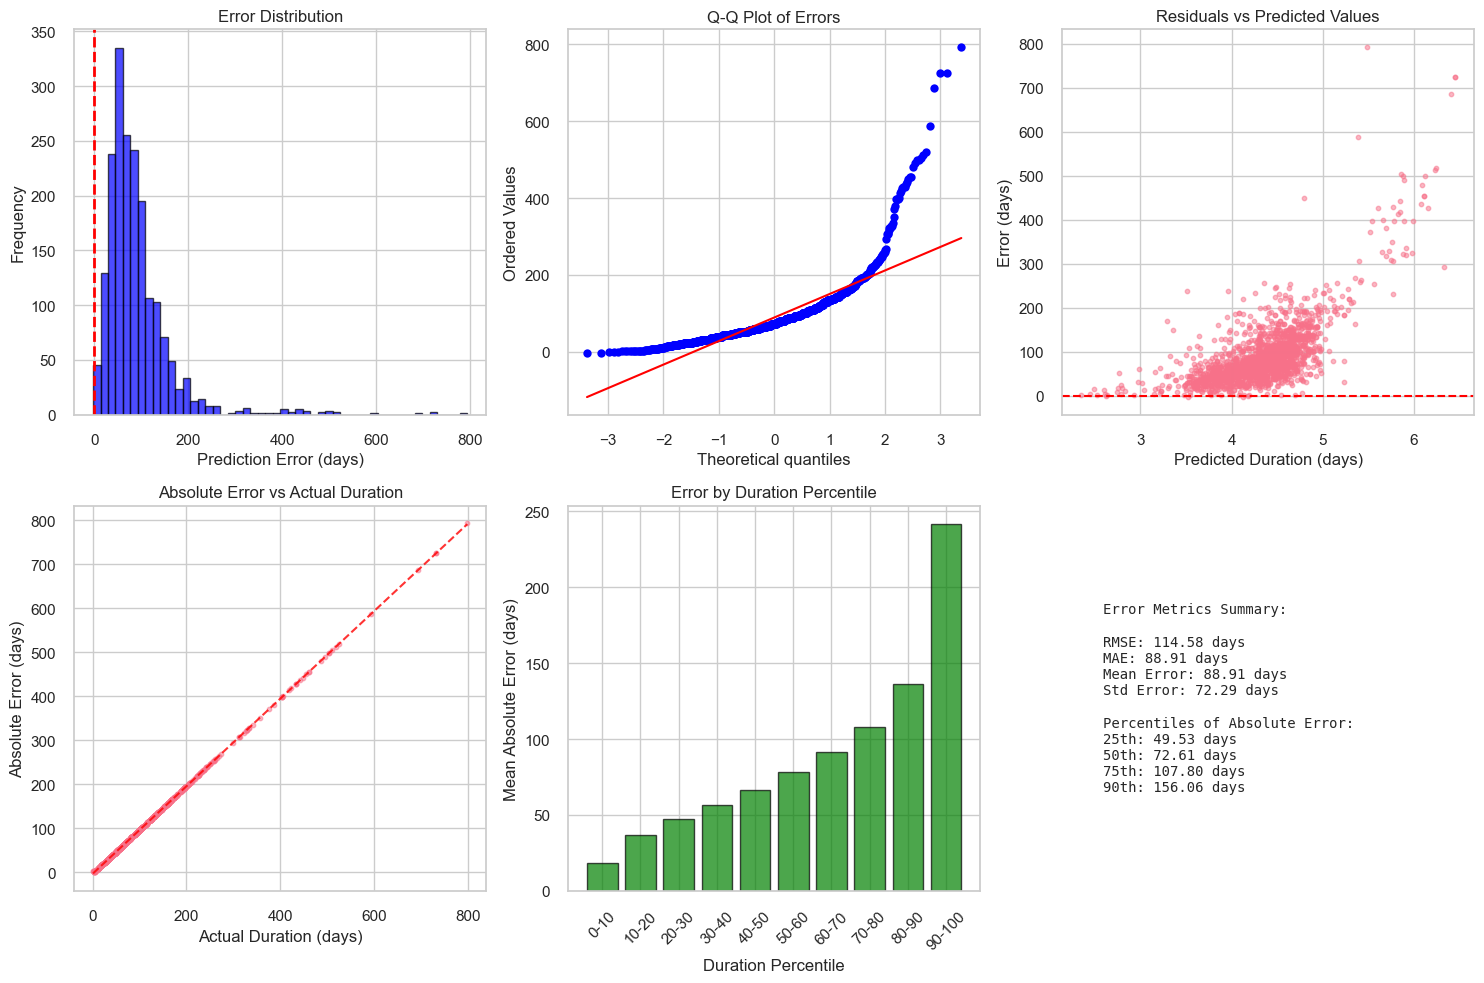

  Error analysis plots saved successfully

Completed analysis for scdb_duration_leakage_controlled_logtarget_v1

PROCESSING MODEL [3]: scdb_duration_full_with_leakage_optuna_v2
Successfully loaded model pipeline from: ../models\scdb_duration_full_with_leakage_optuna_v2\scdb_duration_full_with_leakage_optuna_v2.joblib
Successfully loaded Optuna study from: ../models\scdb_duration_full_with_leakage_optuna_v2\scdb_duration_full_with_leakage_optuna_v2_optuna_study.joblib
Recreating splits with params: {'test_size': 0.2, 'eval_size': 0.15, 'random_state_split': 420}, Stratify: True

1. Checking for Optuna study...
Loaded Optuna study with 100 trials

Generating Optuna visualizations...
  All Optuna visualizations saved successfully

2. Generating SHAP visualizations...


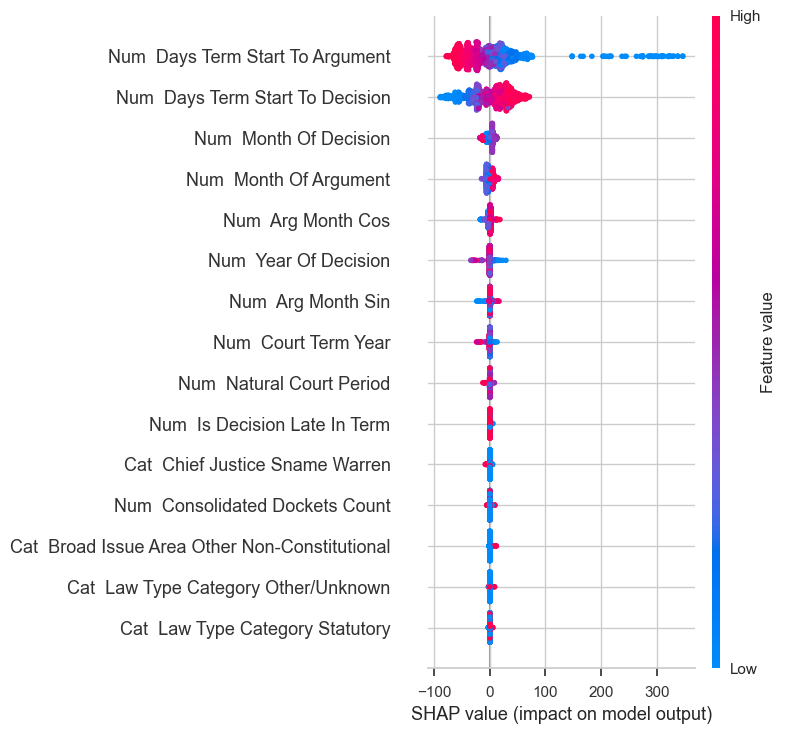

  SHAP plots saved successfully

3. Generating Partial Dependence Plots...

Generating Partial Dependence Plots...


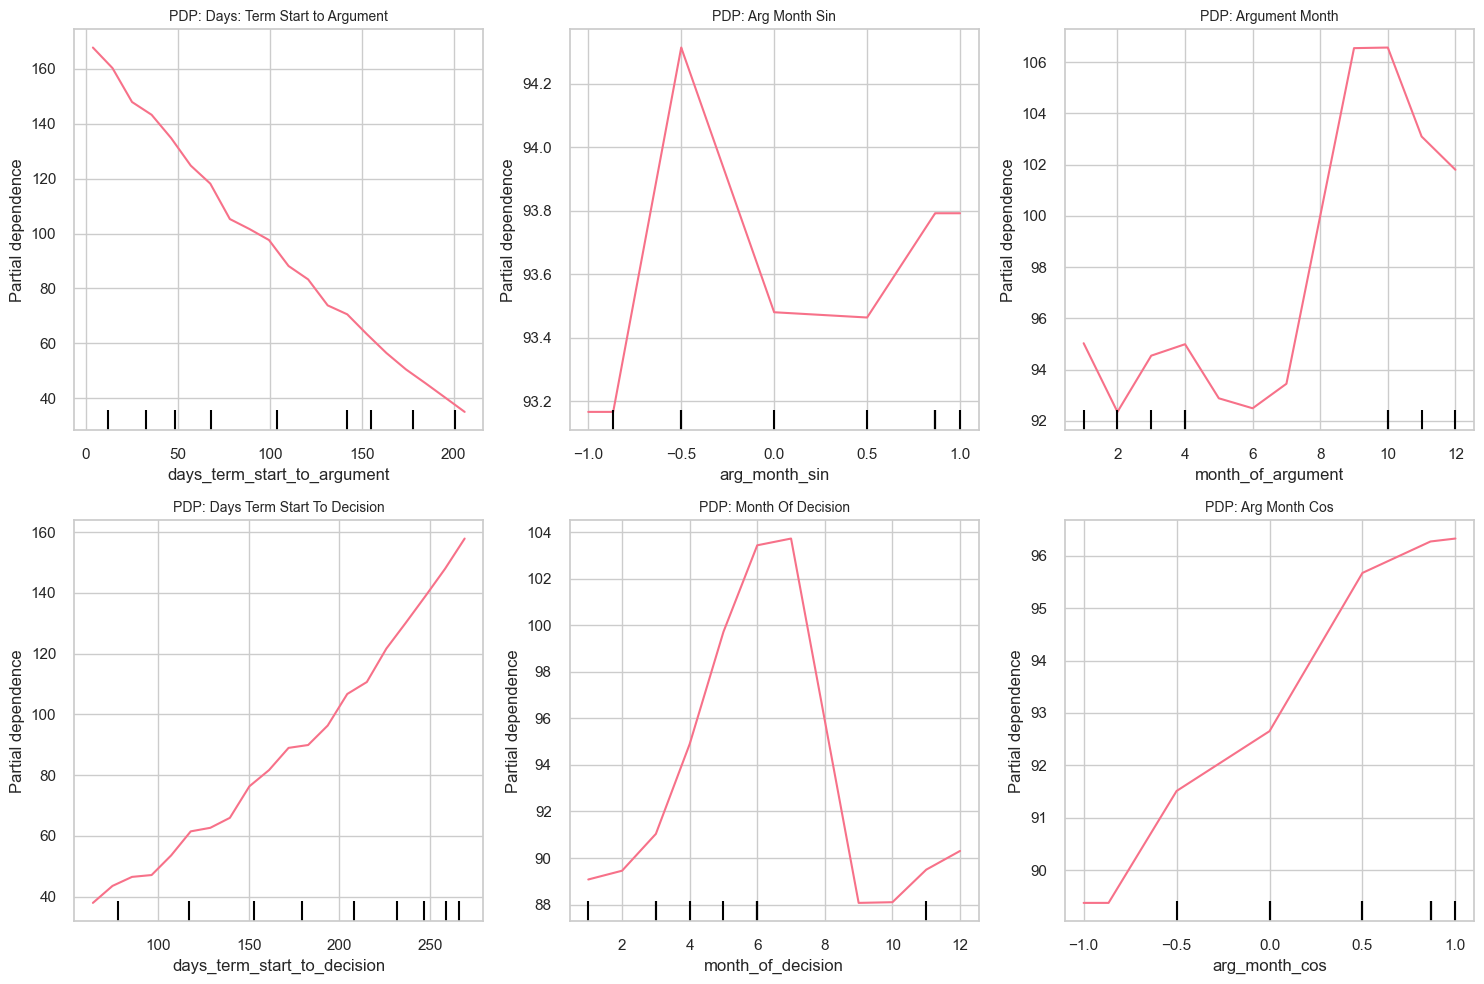

  PDP plots saved successfully

4. Generating ICE Plots...

Generating ICE Plots...


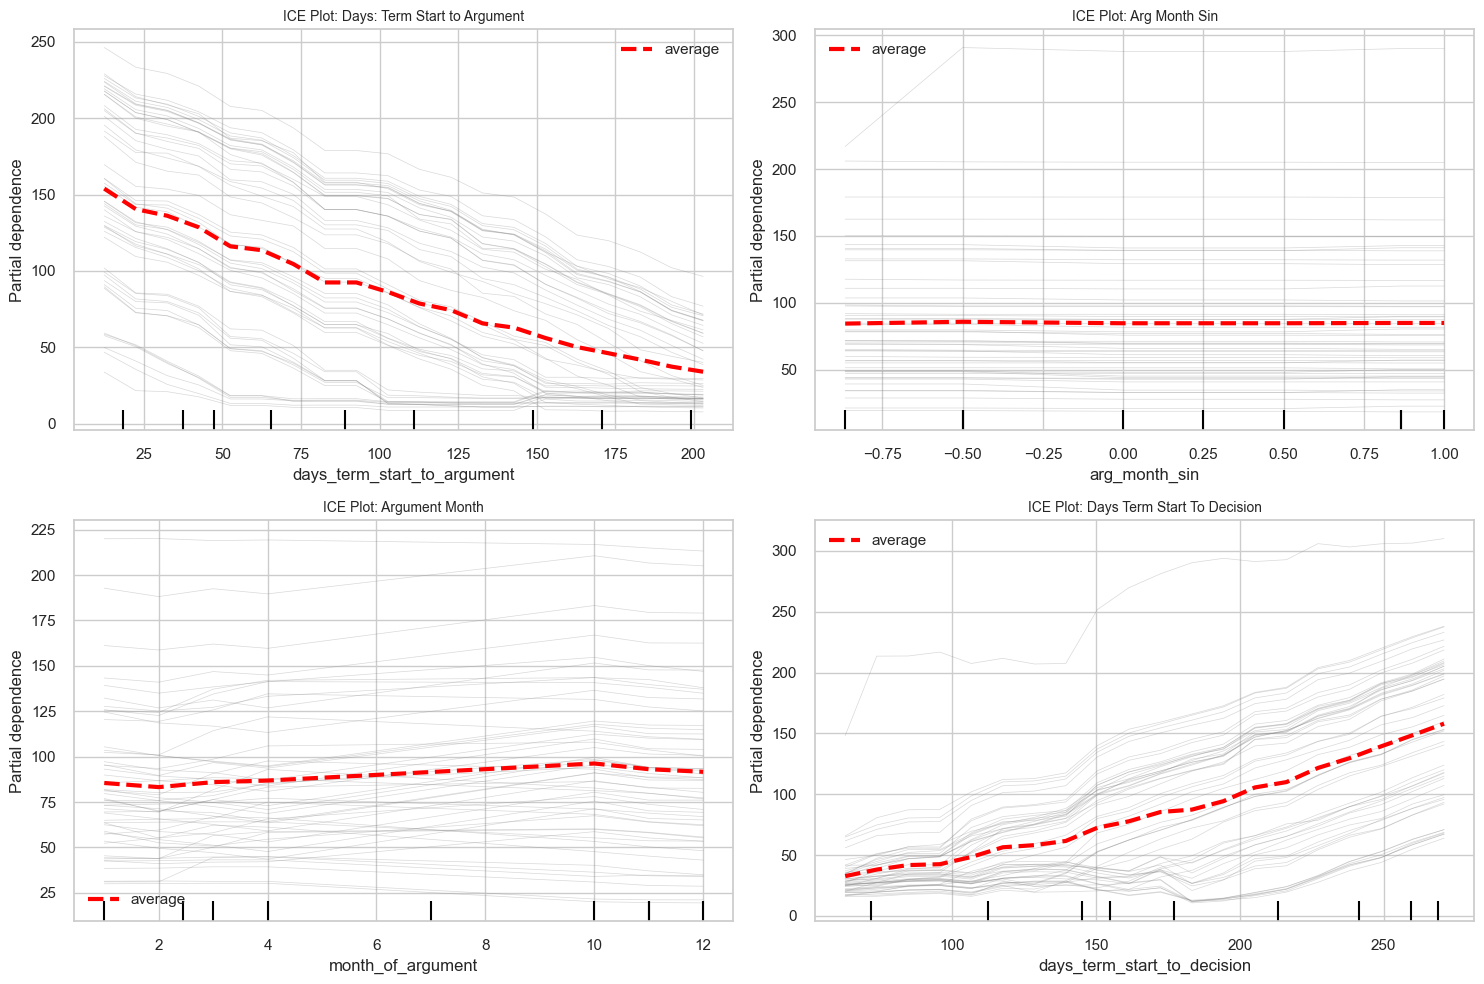

  ICE plots saved successfully

5. Generating Error Analysis...

Generating Error Analysis Plots...


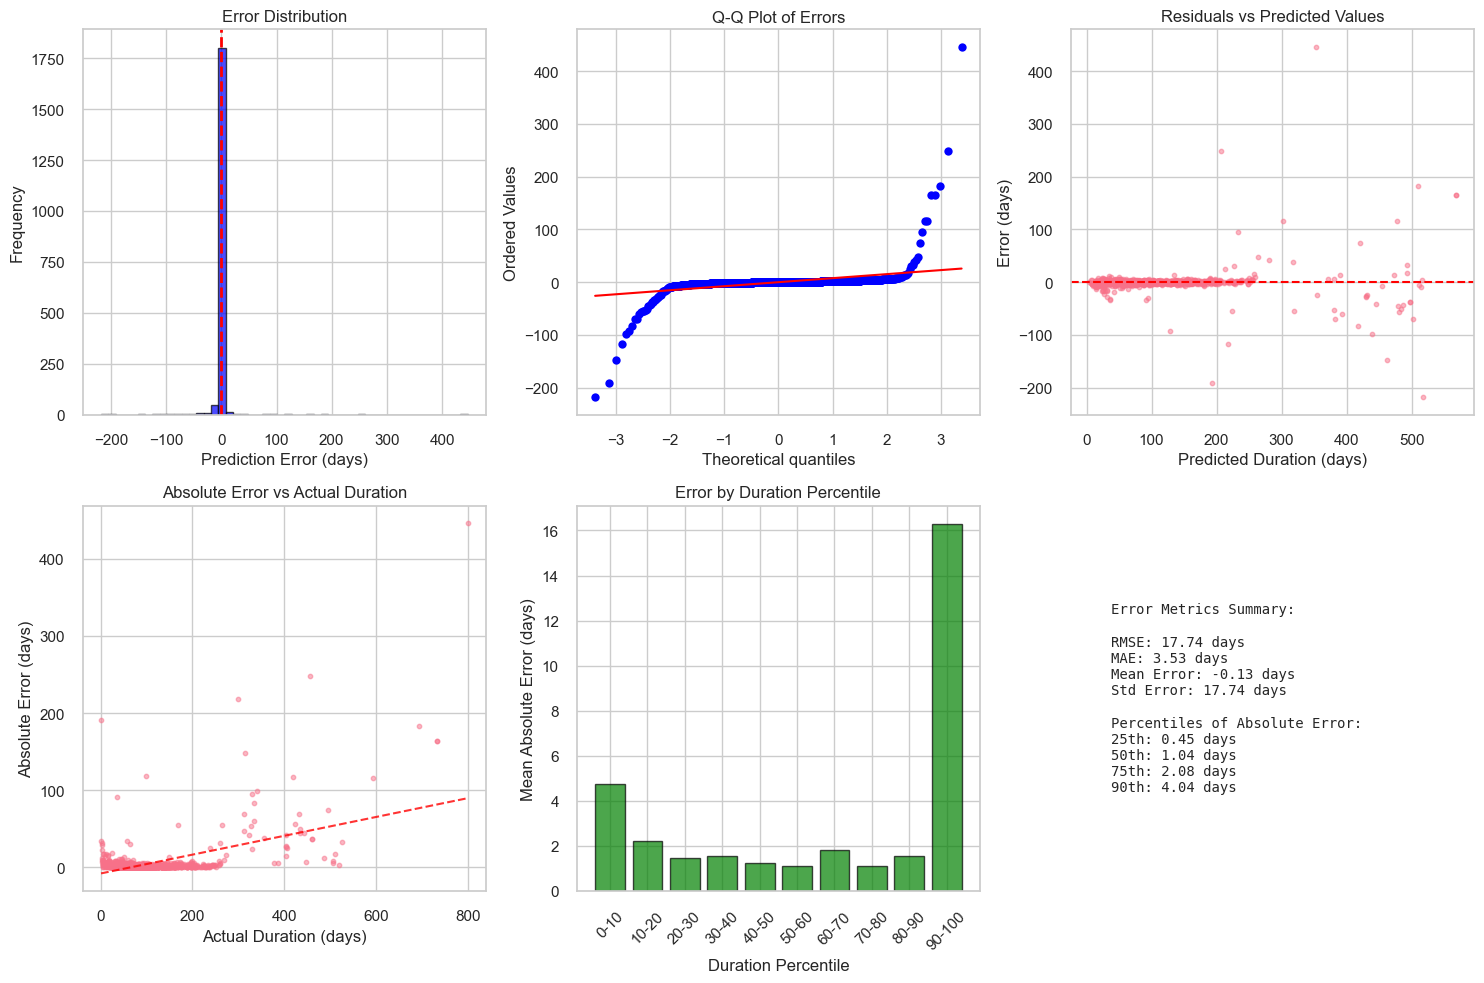

  Error analysis plots saved successfully

Completed analysis for scdb_duration_full_with_leakage_optuna_v2


ANALYSIS COMPLETED


In [45]:
# =============================================================================
# XAI ANALYSIS WITH ALL FUNCTIONS - later will be moved to separate script (.py)
# =============================================================================

import os
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import PartialDependenceDisplay
from typing import Dict, List, Optional, Tuple, Any
import warnings
warnings.filterwarnings('ignore')

# Import custom modules
import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..'))) 
from src.model_utils import list_trained_models, load_model_artifacts, get_data_splits_from_metadata
from src.train_model import XGBoostModelTrainer

# Import XAI libraries
import shap
import lime
import lime.lime_tabular
import dalex as dx
import optuna
import optuna.visualization as vis
import joblib

# Setup plotting style
sns.set_theme(style="whitegrid", palette="husl")
pd.set_option('display.max_columns', 100)
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300

# =============================================================================
# FEATURE NAME MAPPING
# =============================================================================

FEATURE_DISPLAY_NAMES = {
    'month_of_argument': 'Argument Month',
    'days_term_start_to_argument': 'Days: Term Start to Argument',
    'is_argument_late_in_term': 'Late Term Argument',
    'chief_justice_sname': 'Chief Justice',
    'natural_court_period': 'Natural Court Period',
    'court_term_year': 'Court Term Year',
    'case_docket_type': 'Docket Type',
    'jurisdiction_type': 'Jurisdiction Type',
    'broad_issue_area': 'Broad Issue Area',
    'petitioner_type': 'Petitioner Type',
    'respondent_type': 'Respondent Type',
    'lower_court_disagreement': 'Lower Court Disagreement',
    'consolidated_dockets_count': 'Consolidated Dockets',
    'case_origin_type': 'Case Origin Type',
    'case_source_type': 'Case Source Type',
    'cert_reason_category': 'Cert Reason Category',
    'specific_legal_issue_grouped': 'Legal Issue (Grouped)',
    'law_type_category': 'Law Type Category',
    'is_govt_vs_business_case': 'Government vs Business',
    'is_individual_vs_govt_case': 'Individual vs Government',
    'is_state_vs_state_case': 'State vs State',
    'lower_court_ideological_direction': 'Lower Court Ideology',
    'lower_court_disposition_type': 'Lower Court Disposition',
    'lower_court_disagree_ideology': 'Lower Court Disagree Ideology',
    'complexity_score_consolidated_disagree': 'Complexity Score',
    'three_judge_district_court': 'Three Judge District Court',
    'is_admin_economic_case': 'Admin Economic Case',
    'is_federal_circuit_conflict': 'Federal Circuit Conflict',
    'lower_court_disagree_was_missing': 'Lower Court Disagree Missing',
    'three_judge_info_was_missing': 'Three Judge Info Missing'
}

def get_readable_feature_name(feature_name: str) -> str:
    """Convert feature name to readable format"""
    if feature_name in FEATURE_DISPLAY_NAMES:
        return FEATURE_DISPLAY_NAMES[feature_name]
    
    for orig_name, display_name in FEATURE_DISPLAY_NAMES.items():
        if feature_name.startswith(orig_name + '_'):
            suffix = feature_name[len(orig_name)+1:]
            return f"{display_name}: {suffix}"
    
    return feature_name.replace('_', ' ').title()

# =============================================================================
# FIXED PDP FUNCTION
# =============================================================================

def create_pdp_plots_fixed(pipeline, X, feature_names_original, top_n=6, figsize=(15, 10)):
    """Create Partial Dependence Plots with proper feature handling"""
    print("\nGenerating Partial Dependence Plots...")
    
    # Get feature importance from XGBoost
    xgb_model = pipeline.named_steps['regressor']
    preprocessor = pipeline.named_steps['preprocessor']
    
    # Get processed feature names
    feature_names_processed = preprocessor.get_feature_names_out()
    
    # Create importance dataframe
    feature_importance = pd.DataFrame({
        'feature': feature_names_processed,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Get top features that exist in original data
    top_features_to_plot = []
    for _, row in feature_importance.iterrows():
        feat_name = row['feature']
        # Check if this is a one-hot encoded feature
        if feat_name in feature_names_original:
            top_features_to_plot.append(feat_name)
        else:
            # Extract base feature name from one-hot encoded features
            for orig_feat in feature_names_original:
                if feat_name.startswith(f"cat__{orig_feat}_") or feat_name.startswith(f"num__{orig_feat}"):
                    if orig_feat not in top_features_to_plot:
                        top_features_to_plot.append(orig_feat)
                        break
        
        if len(top_features_to_plot) >= top_n:
            break
    
    # Create figure
    fig, axes = plt.subplots(2, 3, figsize=figsize)
    axes = axes.flatten()
    
    # Plot each feature
    for idx, feature_name in enumerate(top_features_to_plot[:6]):
        if idx >= len(axes):
            break
        
        try:
            ax = axes[idx]
            
            # Create PDP display
            display = PartialDependenceDisplay.from_estimator(
                pipeline, X, [feature_name], 
                kind='average',
                ax=ax,
                grid_resolution=20
            )
            
            ax.set_xlabel(get_readable_feature_name(feature_name))
            ax.set_ylabel('Partial Dependence')
            ax.set_title(f'PDP: {get_readable_feature_name(feature_name)}', fontsize=10)
            
        except Exception as e:
            print(f"  Could not create PDP for {feature_name}: {e}")
            axes[idx].text(0.5, 0.5, f"Could not plot\n{feature_name}", 
                          ha='center', va='center', transform=axes[idx].transAxes)
    
    # Hide unused subplots
    for idx in range(len(top_features_to_plot), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    return fig

# =============================================================================
# FIXED ICE FUNCTION
# =============================================================================

def create_ice_plots_fixed(pipeline, X, feature_names_original, top_n=4, n_samples=50, figsize=(15, 10)):
    """Create ICE plots with proper feature handling"""
    print("\nGenerating ICE Plots...")
    
    # Get feature importance
    xgb_model = pipeline.named_steps['regressor']
    preprocessor = pipeline.named_steps['preprocessor']
    feature_names_processed = preprocessor.get_feature_names_out()
    
    feature_importance = pd.DataFrame({
        'feature': feature_names_processed,
        'importance': xgb_model.feature_importances_
    }).sort_values('importance', ascending=False)
    
    # Get top original features
    top_features_to_plot = []
    for _, row in feature_importance.iterrows():
        feat_name = row['feature']
        if feat_name in feature_names_original:
            top_features_to_plot.append(feat_name)
        else:
            for orig_feat in feature_names_original:
                if feat_name.startswith(f"cat__{orig_feat}_") or feat_name.startswith(f"num__{orig_feat}"):
                    if orig_feat not in top_features_to_plot:
                        top_features_to_plot.append(orig_feat)
                        break
        
        if len(top_features_to_plot) >= top_n:
            break
    
    # Sample data
    if len(X) > n_samples:
        sample_idx = np.random.choice(len(X), n_samples, replace=False)
        X_ice = X.iloc[sample_idx]
    else:
        X_ice = X
    
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    axes = axes.flatten()
    
    for idx, feature_name in enumerate(top_features_to_plot[:4]):
        if idx >= len(axes):
            break
        
        try:
            ax = axes[idx]
            
            # Create ICE plot
            display = PartialDependenceDisplay.from_estimator(
                pipeline, X_ice, [feature_name],
                kind='both',  # Shows both individual and average
                ax=ax,
                grid_resolution=20,
                ice_lines_kw={"color": "gray", "alpha": 0.3, "linewidth": 0.5},
                pd_line_kw={"color": "red", "linewidth": 3}
            )
            
            ax.set_xlabel(get_readable_feature_name(feature_name))
            ax.set_ylabel('Prediction')
            ax.set_title(f'ICE Plot: {get_readable_feature_name(feature_name)}', fontsize=10)
            
        except Exception as e:
            print(f"  Could not create ICE for {feature_name}: {e}")
            axes[idx].text(0.5, 0.5, f"Could not plot\n{feature_name}", 
                          ha='center', va='center', transform=axes[idx].transAxes)
    
    # Hide unused subplots
    for idx in range(len(top_features_to_plot), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    return fig

# =============================================================================
# ERROR ANALYSIS FUNCTION
# =============================================================================

def create_error_analysis_plots(y_true, y_pred, X_test, feature_names, figsize=(15, 10)):
    """Create comprehensive error analysis plots"""
    print("\nGenerating Error Analysis Plots...")
    
    errors = y_true - y_pred
    abs_errors = np.abs(errors)
    
    fig = plt.figure(figsize=figsize)
    
    # 1. Error Distribution
    plt.subplot(2, 3, 1)
    plt.hist(errors, bins=50, alpha=0.7, color='blue', edgecolor='black')
    plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
    plt.xlabel('Prediction Error (days)')
    plt.ylabel('Frequency')
    plt.title('Error Distribution')
    
    # 2. Q-Q Plot
    plt.subplot(2, 3, 2)
    from scipy import stats
    stats.probplot(errors, dist="norm", plot=plt)
    plt.title('Q-Q Plot of Errors')
    
    # 3. Error vs Predicted
    plt.subplot(2, 3, 3)
    plt.scatter(y_pred, errors, alpha=0.5, s=10)
    plt.axhline(y=0, color='red', linestyle='--')
    plt.xlabel('Predicted Duration (days)')
    plt.ylabel('Error (days)')
    plt.title('Residuals vs Predicted Values')
    
    # 4. Absolute Error vs Actual
    plt.subplot(2, 3, 4)
    plt.scatter(y_true, abs_errors, alpha=0.5, s=10)
    z = np.polyfit(y_true, abs_errors, 1)
    p = np.poly1d(z)
    plt.plot(sorted(y_true), p(sorted(y_true)), "r--", alpha=0.8)
    plt.xlabel('Actual Duration (days)')
    plt.ylabel('Absolute Error (days)')
    plt.title('Absolute Error vs Actual Duration')
    
    # 5. Error by Percentile
    plt.subplot(2, 3, 5)
    percentiles = np.percentile(y_true, np.arange(0, 101, 10))
    error_by_percentile = []
    for i in range(len(percentiles)-1):
        mask = (y_true >= percentiles[i]) & (y_true < percentiles[i+1])
        if np.any(mask):
            error_by_percentile.append(np.mean(abs_errors[mask]))
        else:
            error_by_percentile.append(0)
    
    plt.bar(range(len(error_by_percentile)), error_by_percentile, 
            color='green', alpha=0.7, edgecolor='black')
    plt.xlabel('Duration Percentile')
    plt.ylabel('Mean Absolute Error (days)')
    plt.title('Error by Duration Percentile')
    plt.xticks(range(len(error_by_percentile)), 
               [f'{i*10}-{(i+1)*10}' for i in range(len(error_by_percentile))], 
               rotation=45)
    
    # 6. Error Metrics Summary
    plt.subplot(2, 3, 6)
    plt.axis('off')
    metrics_text = f"""Error Metrics Summary:
    
RMSE: {np.sqrt(mean_squared_error(y_true, y_pred)):.2f} days
MAE: {mean_absolute_error(y_true, y_pred):.2f} days
Mean Error: {np.mean(errors):.2f} days
Std Error: {np.std(errors):.2f} days
    
Percentiles of Absolute Error:
25th: {np.percentile(abs_errors, 25):.2f} days
50th: {np.percentile(abs_errors, 50):.2f} days
75th: {np.percentile(abs_errors, 75):.2f} days
90th: {np.percentile(abs_errors, 90):.2f} days"""
    
    plt.text(0.1, 0.5, metrics_text, fontsize=10, verticalalignment='center',
             fontfamily='monospace')
    
    plt.tight_layout()
    return fig

# =============================================================================
# OPTUNA VISUALIZATION FUNCTIONS
# =============================================================================

def run_optuna_visualizations(model_path, model_name):
    """Load and visualize Optuna study from saved model artifacts"""
    study_path = os.path.join(model_path, f"{model_name}_optuna_study.joblib")
    
    if not os.path.exists(study_path):
        print(f"No Optuna study found at {study_path}")
        return False
    
    try:
        study = joblib.load(study_path)
        print(f"Loaded Optuna study with {len(study.trials)} trials")
        
        plots_dir = os.path.join(model_path, 'plots', 'optuna')
        os.makedirs(plots_dir, exist_ok=True)
        
        create_optuna_visualizations(study, model_name, plots_dir)
        return True
        
    except Exception as e:
        print(f"Failed to load or visualize Optuna study: {e}")
        return False

def create_optuna_visualizations(study, model_name, save_dir):
    """Create comprehensive Optuna study visualizations"""
    print("\nGenerating Optuna visualizations...")
    
    try:
        # 1. Optimization History
        fig_history = vis.plot_optimization_history(study)
        fig_history.update_layout(title=f'Optimization History - {model_name}')
        fig_history.write_image(os.path.join(save_dir, 'optuna_history.png'))
        fig_history.write_html(os.path.join(save_dir, 'optuna_history.html'))
        
        # 2. Parameter Importance
        fig_importance = vis.plot_param_importances(study)
        fig_importance.update_layout(title=f'Parameter Importance - {model_name}')
        fig_importance.write_image(os.path.join(save_dir, 'optuna_param_importance.png'))
        
        # 3. Parallel Coordinate Plot
        fig_parallel = vis.plot_parallel_coordinate(study)
        fig_parallel.update_layout(title=f'Parallel Coordinates - {model_name}')
        fig_parallel.write_image(os.path.join(save_dir, 'optuna_parallel.png'))
        
        # 4. Slice Plot
        fig_slice = vis.plot_slice(study)
        fig_slice.update_layout(title=f'Parameter Slices - {model_name}')
        fig_slice.write_image(os.path.join(save_dir, 'optuna_slice.png'))
        
        # 5. Contour Plot
        fig_contour = vis.plot_contour(study)
        fig_contour.update_layout(title=f'Parameter Contours - {model_name}')
        fig_contour.write_image(os.path.join(save_dir, 'optuna_contour.png'))
        
        # 6. EDF Plot
        fig_edf = vis.plot_edf(study)
        fig_edf.update_layout(title=f'Empirical Distribution Function - {model_name}')
        fig_edf.write_image(os.path.join(save_dir, 'optuna_edf.png'))
        
        # 7. Timeline Plot
        fig_timeline = vis.plot_timeline(study)
        fig_timeline.update_layout(title=f'Optimization Timeline - {model_name}')
        fig_timeline.write_image(os.path.join(save_dir, 'optuna_timeline.png'))
        
        print("  All Optuna visualizations saved successfully")
        
    except Exception as e:
        print(f"  Some Optuna visualizations failed: {e}")

# =============================================================================
# MAIN ANALYSIS EXECUTION
# =============================================================================

# Load data
print("\n--- Loading original dataset ---")
if 'df_cleaned' in locals() and 'y' in locals():
    print("Using pre-loaded df_cleaned and y.")
    DATA_LOADED = True
else:
    print("ERROR: df_cleaned and y are not defined.")
    DATA_LOADED = False

if DATA_LOADED:
    # Scan for models
    available_models = list_trained_models(models_base_dir="../models")
    sorted_by_rmse = sorted(available_models, key=lambda x: x.get('test_rmse', float('inf')))
    
    print(f"\nFound {len(sorted_by_rmse)} models:")
    for i, model_info in enumerate(sorted_by_rmse):
        rmse_str = f"{model_info.get('test_rmse'):.2f}" if model_info.get('test_rmse') else "N/A"
        print(f"  [{i}] {model_info['name']} (RMSE: {rmse_str})")
    
    # Process selected models
    MODEL_INDICES_TO_ANALYZE = [0, 3]
    
    for model_index in MODEL_INDICES_TO_ANALYZE:
        if model_index >= len(sorted_by_rmse):
            continue
            
        selected_model_info = sorted_by_rmse[model_index]
        model_name = selected_model_info['name']
        print(f"\n{'='*80}")
        print(f"PROCESSING MODEL [{model_index}]: {model_name}")
        print('='*80)
        
        # Load model
        loaded_artifacts = load_model_artifacts(selected_model_info['path'])
        if not loaded_artifacts:
            continue
            
        # Recreate data splits
        metadata_loaded = loaded_artifacts.get('metadata', {})
        recreated_splits = get_data_splits_from_metadata(df_cleaned, y, metadata_loaded)
        if not recreated_splits:
            continue
            
        X_train_re, X_val_re, X_test_re, y_train_re, y_val_re, y_test_re = recreated_splits
        pipeline_loaded = loaded_artifacts['pipeline']
        xgb_model_loaded = loaded_artifacts['xgb_model']
        preprocessor_loaded = loaded_artifacts['preprocessor']
        
        # Setup directories
        model_specific_plots_dir = os.path.join(selected_model_info['path'], 'plots')
        os.makedirs(model_specific_plots_dir, exist_ok=True)
        
        # Get feature names and predictions
        feature_names_processed = preprocessor_loaded.get_feature_names_out()
        X_test_processed_df = pd.DataFrame(
            preprocessor_loaded.transform(X_test_re), 
            columns=feature_names_processed
        )
        y_pred = pipeline_loaded.predict(X_test_re)
        
        # 1. Run Optuna visualizations if available
        print("\n1. Checking for Optuna study...")
        run_optuna_visualizations(selected_model_info['path'], model_name)
        
        # 2. SHAP Analysis
        try:
            print("\n2. Generating SHAP visualizations...")
            shap_explainer = shap.TreeExplainer(xgb_model_loaded)
            shap_values = shap_explainer.shap_values(X_test_processed_df)
            
            plt.figure(figsize=(10, 8))
            shap.summary_plot(shap_values, X_test_processed_df, 
                            feature_names=[get_readable_feature_name(f) for f in feature_names_processed],
                            max_display=15, show=False)
            plt.tight_layout()
            plt.savefig(os.path.join(model_specific_plots_dir, 'shap_summary.png'), dpi=300)
            plt.show()
            plt.close()
            print("  SHAP plots saved successfully")
        except Exception as e:
            print(f"  SHAP analysis failed: {e}")
        
        # 3. Fixed PDP plots
        try:
            print("\n3. Generating Partial Dependence Plots...")
            pdp_fig = create_pdp_plots_fixed(pipeline_loaded, X_test_re, X_test_re.columns.tolist())
            pdp_fig.savefig(os.path.join(model_specific_plots_dir, 'pdp_plots.png'), dpi=300)
            plt.show()
            plt.close()
            print("  PDP plots saved successfully")
        except Exception as e:
            print(f"  PDP plots failed: {e}")
        
        # 4. Fixed ICE plots
        try:
            print("\n4. Generating ICE Plots...")
            ice_fig = create_ice_plots_fixed(pipeline_loaded, X_test_re, X_test_re.columns.tolist())
            ice_fig.savefig(os.path.join(model_specific_plots_dir, 'ice_plots.png'), dpi=300)
            plt.show()
            plt.close()
            print("  ICE plots saved successfully")
        except Exception as e:
            print(f"  ICE plots failed: {e}")
        
        # 5. Error Analysis
        try:
            print("\n5. Generating Error Analysis...")
            error_fig = create_error_analysis_plots(y_test_re, y_pred, X_test_re, X_test_re.columns.tolist())
            error_fig.savefig(os.path.join(model_specific_plots_dir, 'error_analysis.png'), dpi=300)
            plt.show()
            plt.close()
            print("  Error analysis plots saved successfully")
        except Exception as e:
            print(f"  Error analysis failed: {e}")
        
        print(f"\nCompleted analysis for {model_name}")

print("\n\nANALYSIS COMPLETED")

## 7. Results 